# Simple simulation of the transmon qubit (always run to load parameters)
- 1st dimesion of output is $N_\text{ext}$
- 2nd dimension out ouput is $\Phi_\text{ext}$
- 3rd dimension is the ith energy level or eigenvector

In [1]:
%matplotlib notebook
import logging

from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from quantum_builder import QuantumBuilder
import scqubits as scq
import ipywidgets


from utils import plotter

plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

R_square_room_temperature = {'Dynamic-20sccm': 6700.0, 'Static-0.4mBar': 17000, 'Static-0.25mBar': 12170.0, 
                                'Static-0.1mBar': 10_200, 
#                              'Static-0.1mBar': 9500, 
#                              'Static-0.1mBar': 5670.0, 
#                              'Static-0.1mBar': 6650.0,  # from latest july 2021 photon source run
                             'Static-0.13mBar': 8000}
R_cold_scaling = 1.1
JJ_x_scaling = 1.04
JJ_y_scaling = 1.05

def eval_expected_ej0(resistance_rt):
    EJ0 = Rq / (resistance_rt * RESISTANCE_COLD_SCALING) * Delta / 2
    return EJ0/h/GHz

def eval_resitance_from_ej0(x_side: float, y_side: float, EJ0: float):
    N_squares= x_side/100 * y_side/100
    EJ0 = EJ0 * h * GHz
    return Rq * N_squares * Delta / 2 / EJ0 / kOhm

def c_interdigitated(W: float, L: float, N: int):
    return c * N * (W + L)

def ec_interdigitated(W: float, L: float, N: int):
    Ec = e**2 / (2 * c_interdigitated(W, L, N)) / h / GHz
    return Ec

def c_xmon(L: float, S: float):
    return c * 4 * (L - 2 * S)

def ec_xmon(S, L):
    S = S*um
    L = L*um
    Ec = e**2 / (2 * c_xmon(L, S))
    return Ec / h / GHz

def evaluating_n_squares(EJ0: float, oxidation: str):
    EJ0 = EJ0 * GHz * h
    N_squares = EJ0 * R_square_room_temperature[oxidation] * R_cold_scaling / Rq * 2 / Delta
    return N_squares

"""
Evaluates exepcted Ej0 from the design parameters and known scalings
jj_side:              The side off the designed JJ in nm
"""
def eval_expected_ej0(jj_side, oxidation):
    x_side = jj_side; y_side = jj_side;
    x = jj_side * JJ_x_scaling
    y = jj_side * JJ_y_scaling

    # Number of 100x100nm² squares
    N_squares = x/100 * y/100
    EJ0 = Rq / (R_square_room_temperature[oxidation] * R_cold_scaling / N_squares) * Delta / 2
    return EJ0/h/GHz


In [2]:
N_squares = 4
EJ0 = Rq / (R_square_room_temperature["Dynamic-20sccm"] * R_cold_scaling / N_squares) * Delta / 2
EJ0 / h / GHz

82.14840365532687

## For copy-pasta

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.15 (GHz)
EJ0:                                              42.45 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          11
jj_squares:                                       1.00 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           3.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.51 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             124.82 (fF)
Critical Current:                                 0.09 (µA)
JJ Resistance:                                    3.57 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


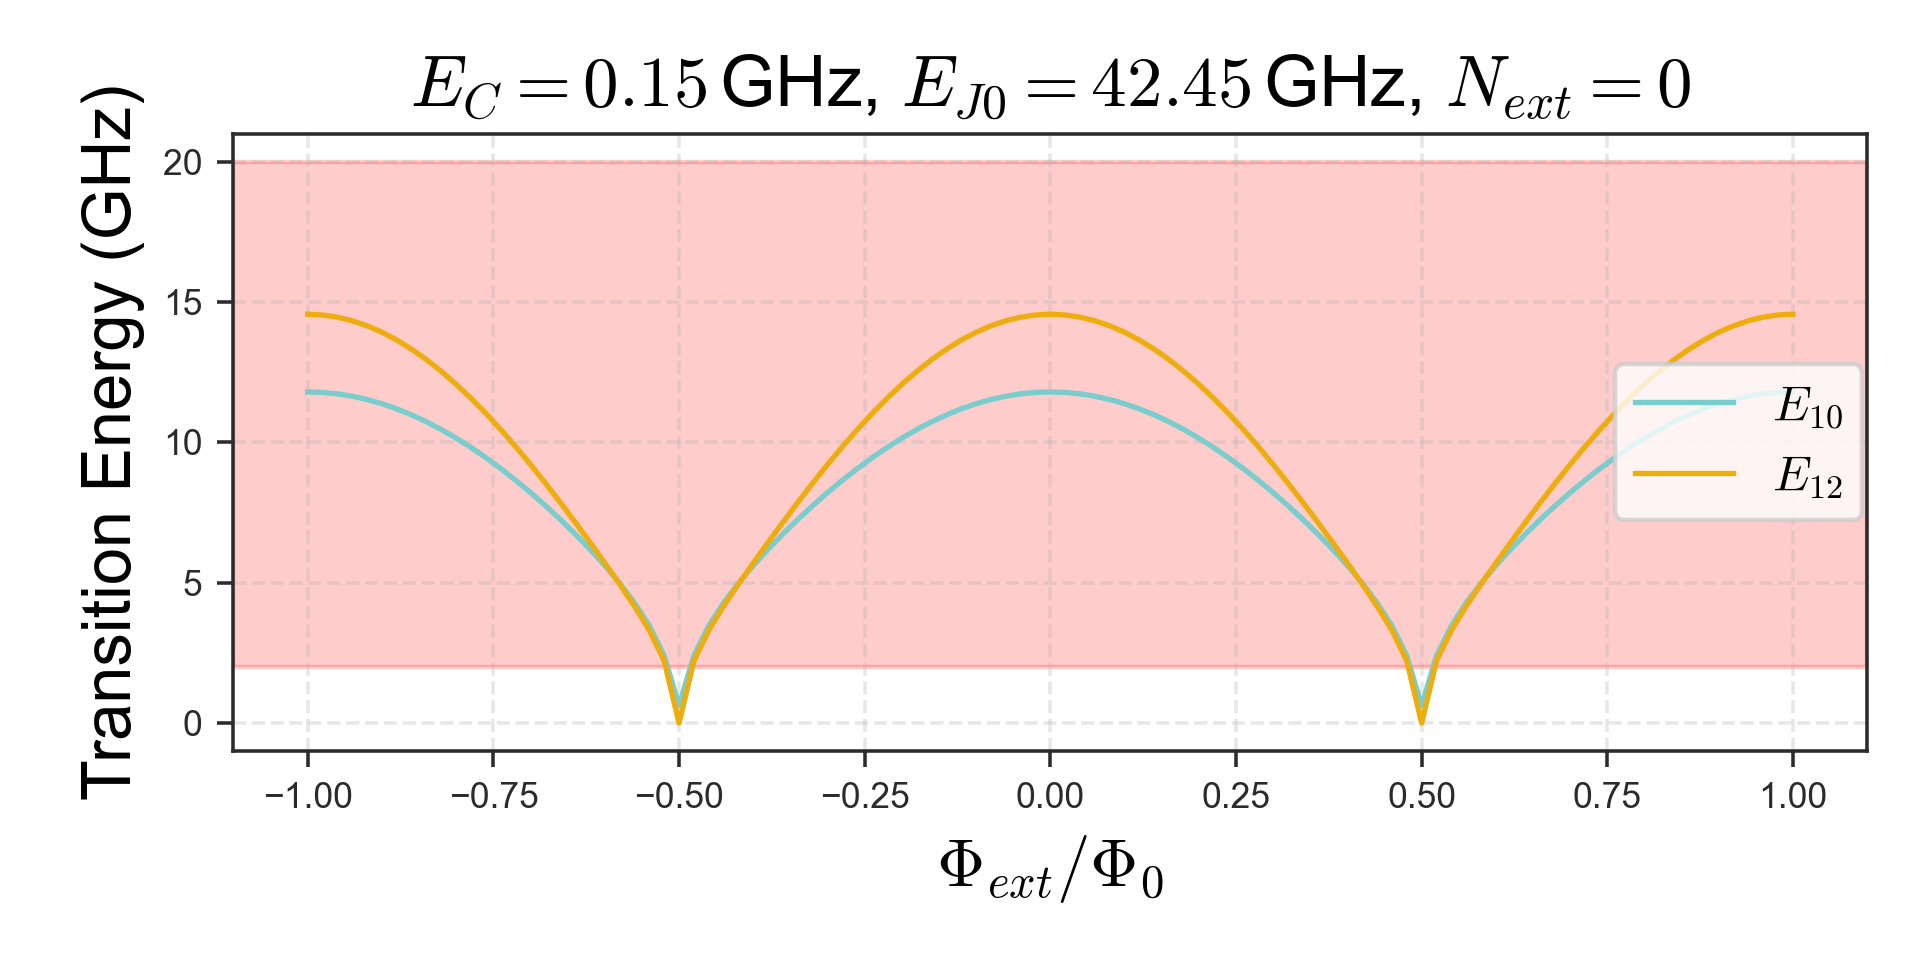

In [6]:
# Geometrical Parameters
# Distances will be in µm
L_gate = 30
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

no_100x100_jj_squares = 1

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 11,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

N_ext_list = [0]
flux_ext_list = np.linspace(-1, 1, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3, 
    use_sparse_matrix=False)

# Plot simulation and spectrum
fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

ax.plot(flux_ext_list, transition01,
           linestyle="-",
           color=COLORMAP_01[0],
           label="$E_{10}$"
          )
ax.plot(flux_ext_list, transition12,
           linestyle="-",
           color=COLORMAP_01[1],
           label="$E_{12}$"
          )

ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $N_{{ext}}={N_ext_list[0]}$", fontsize=16)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(loc="center right",
           borderaxespad=0.1)
ax.axhspan(2, 20, color='red', alpha=0.2)

plt.tight_layout()

# Simulation different charge states 
- 1st dimesion of output is $N_\text{ext}$
- 2nd dimension out ouput is $\Phi_\text{ext}$
- 3rd dimension is the ith energy level or eigenvector

In [6]:
QUBIT_PARAMETERS = {
    "C_gate": 1 * fF,
    "C_transmon": 1 * fF,
    "jj_squares": 1,
    "number_of_charge_states": 11,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

N_ext_list = np.linspace(-2.5, 2.5, 201)
flux_ext_list = [0]
number_of_levels_to_simulate = 3
use_sparse_matrix = False

EC = 17.5
EJ0 = 10
transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

EC = 70
EJ0 = 0.4 
transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
simulation_2 = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               6.39 (GHz)
EJ0:                                              42.45 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          11
jj_squares:                                       1.00 (fF)
C_transmon:                                       1.00 (fF)
C_gate:                                           1.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.51 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             3.02 (fF)
Critical Current:                                 0.09 (µA)
JJ Resistance:                                    3.57 (k𝛀)


transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       17.5
EJ0:      10


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon

<IPython.core.display.Javascript object>


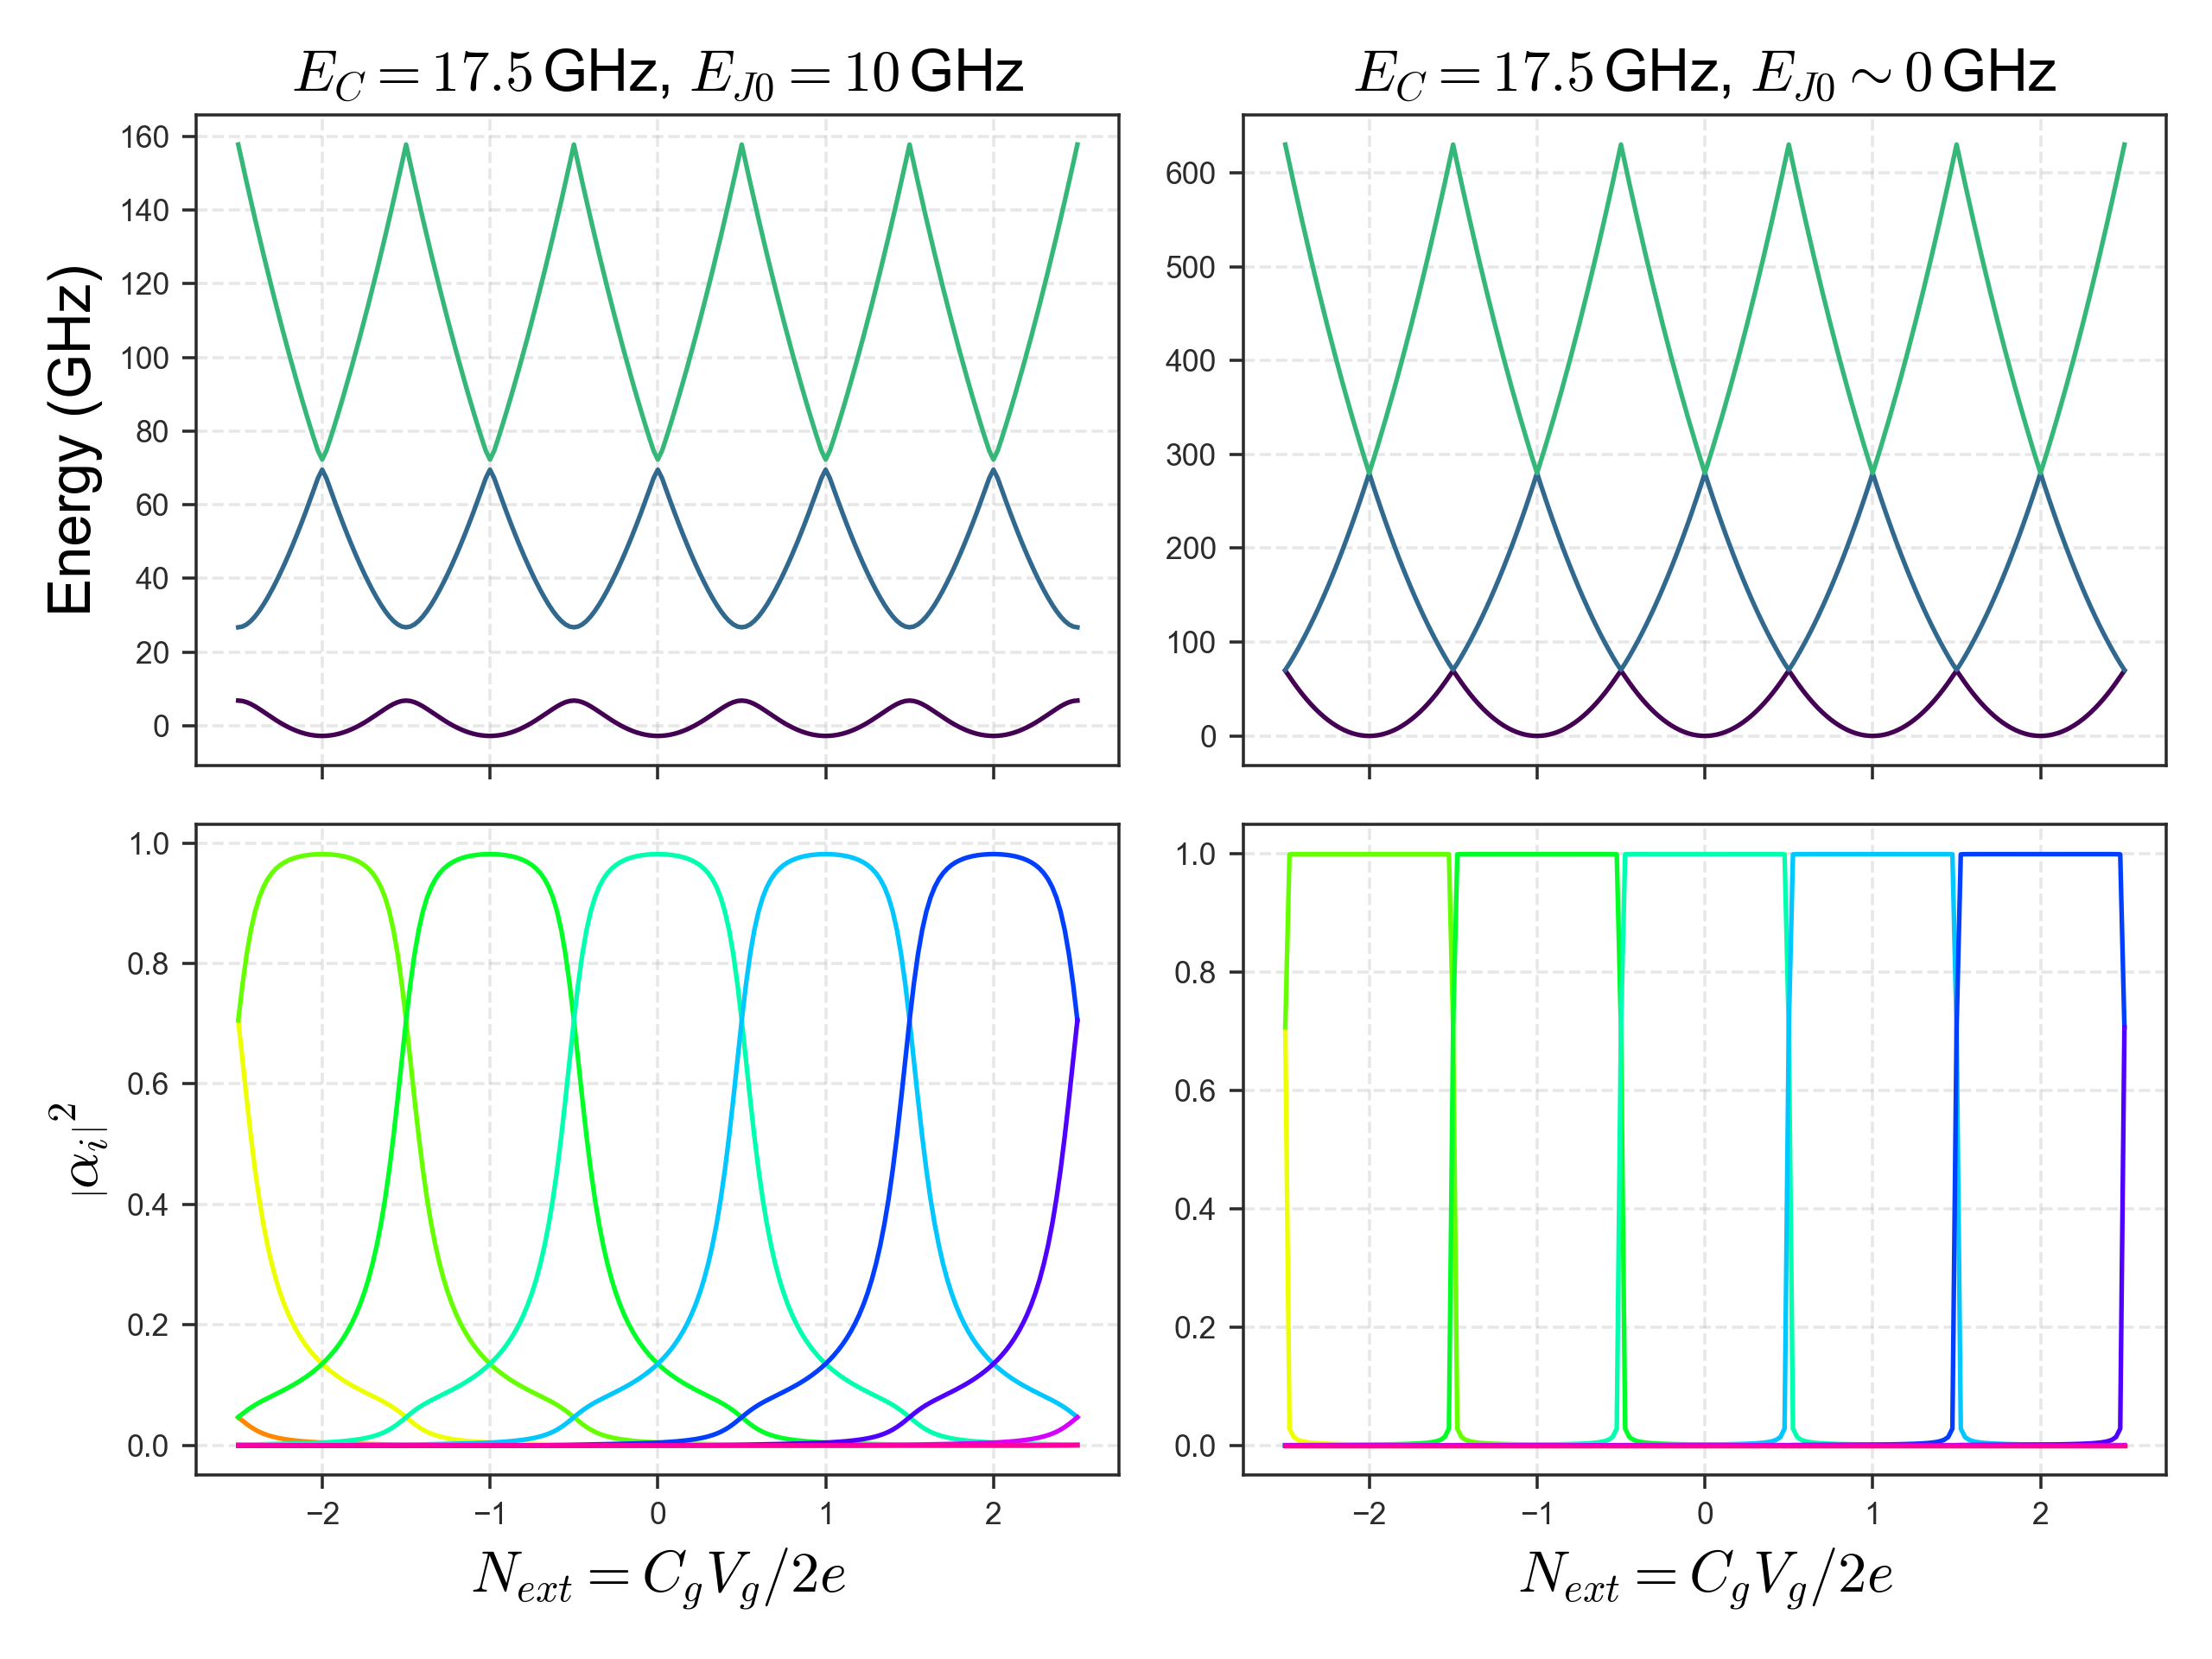

In [7]:
%matplotlib notebook

# 1 - plot simulation and spectrum
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

for level in range(number_of_levels_to_simulate):
    ax[0][0].plot(N_ext_list, simulation["eigvals"][:,0,level],
        color=COLORMAP_ENERGY(level / number_of_levels_to_simulate),
        linestyle="-")
for charge_state in range(QUBIT_PARAMETERS["number_of_charge_states"]):
    ax[1][0].plot(N_ext_list, np.abs(simulation["eigvecs"][:, 0, 0, charge_state]),
        color=COLORMAP_STATE(charge_state / QUBIT_PARAMETERS["number_of_charge_states"]),
        linestyle="-")
    
for level in range(number_of_levels_to_simulate):
    ax[0][1].plot(N_ext_list, simulation_2["eigvals"][:,0,level],
        color=COLORMAP_ENERGY(level / number_of_levels_to_simulate),
        linestyle="-")
for charge_state in range(QUBIT_PARAMETERS["number_of_charge_states"]):
    ax[1][1].plot(N_ext_list, np.abs(simulation_2["eigvecs"][:, 0, 0, charge_state]),
        color=COLORMAP_STATE(charge_state / QUBIT_PARAMETERS["number_of_charge_states"]),
        linestyle="-")

ax[0][0].set_title("$E_C=17.5\,$GHz, $E_{J0}=10\,$GHz", fontsize=15)
ax[0][0].set_ylabel("Energy (GHz)", fontsize=15)
ax[1][0].set_ylabel(r"$\left|\alpha_i\right|^2$", fontsize=15)    
ax[1][0].set_xlabel("$N_{ext} = C_gV_g/2e$", fontsize=15)
ax[0][1].set_title("$E_C=17.5\,$GHz, $E_{J0}\sim 0\,$GHz", fontsize=15)
ax[1][1].set_xlabel("$N_{ext} = C_gV_g/2e$", fontsize=15)
plt.tight_layout()

# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/cooper-pair-box-as-a-function-of-next.pdf")

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               6.39 (GHz)
EJ0:                                              42.45 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          11
jj_squares:                                       1.00 (fF)
C_transmon:                                       1.00 (fF)
C_gate:                                           1.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.51 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             3.02 (fF)
Critical Current:                                 0.09 (µA)
JJ Resistance:                                    3.57 (k𝛀)


transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       100
EJ0:      10


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_

<IPython.core.display.Javascript object>


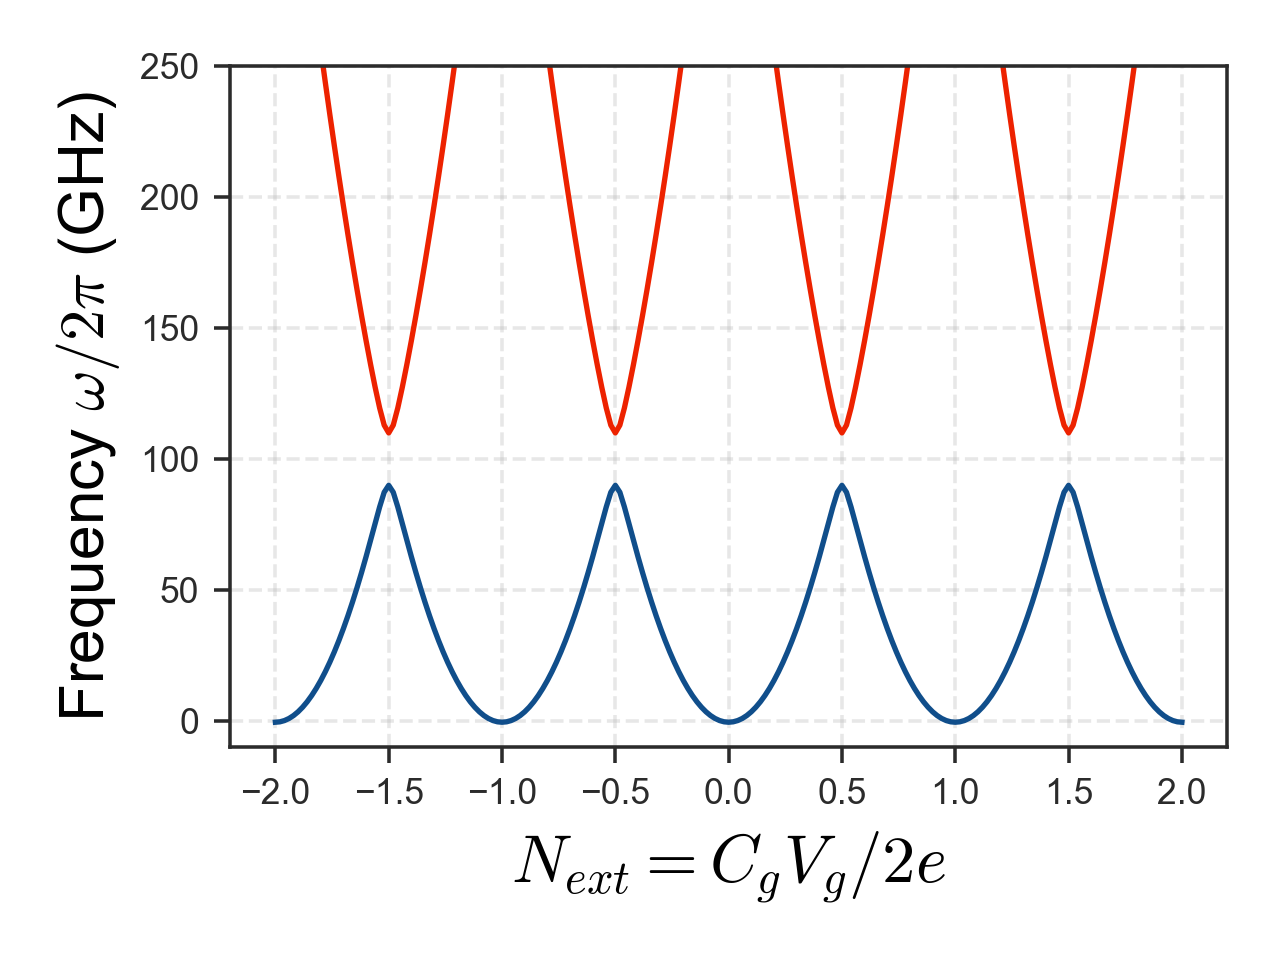

In [20]:
QUBIT_PARAMETERS = {
    "C_gate": 1 * fF,
    "C_transmon": 1 * fF,
    "jj_squares": 1,
    "number_of_charge_states": 11,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

N_ext_list = np.linspace(-2, 2, 201)
flux_ext_list = [0]
number_of_levels_to_simulate = 2
use_sparse_matrix = False

EC = 100
EJ0 = 10
transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

# 1 - plot simulation and spectrum
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
COL = [MY_COLOURS["DarkBlue"], MY_COLOURS["DarkRed"]]
for level in range(number_of_levels_to_simulate):
    ax.plot(N_ext_list, simulation["eigvals"][:,0,level],
        color=COL[level],
        linestyle="-")
ax.set_ylim([-10, 250])
plt.tight_layout()

# ax.set_ylabel("Energy (GHz)", fontsize=15)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.set_ylabel(r"$\left|\alpha_i\right|^2$", fontsize=15)    
ax.set_xlabel("$N_{ext} = C_gV_g/2e$", fontsize=15)
plt.tight_layout()

plt.savefig("transmon-ejo-10.svg")

## 3D

transmon_qubit_constant_manager:118:override_parameters
⮑  Overriding to the following values:
EC:       70
EJ0:      10


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


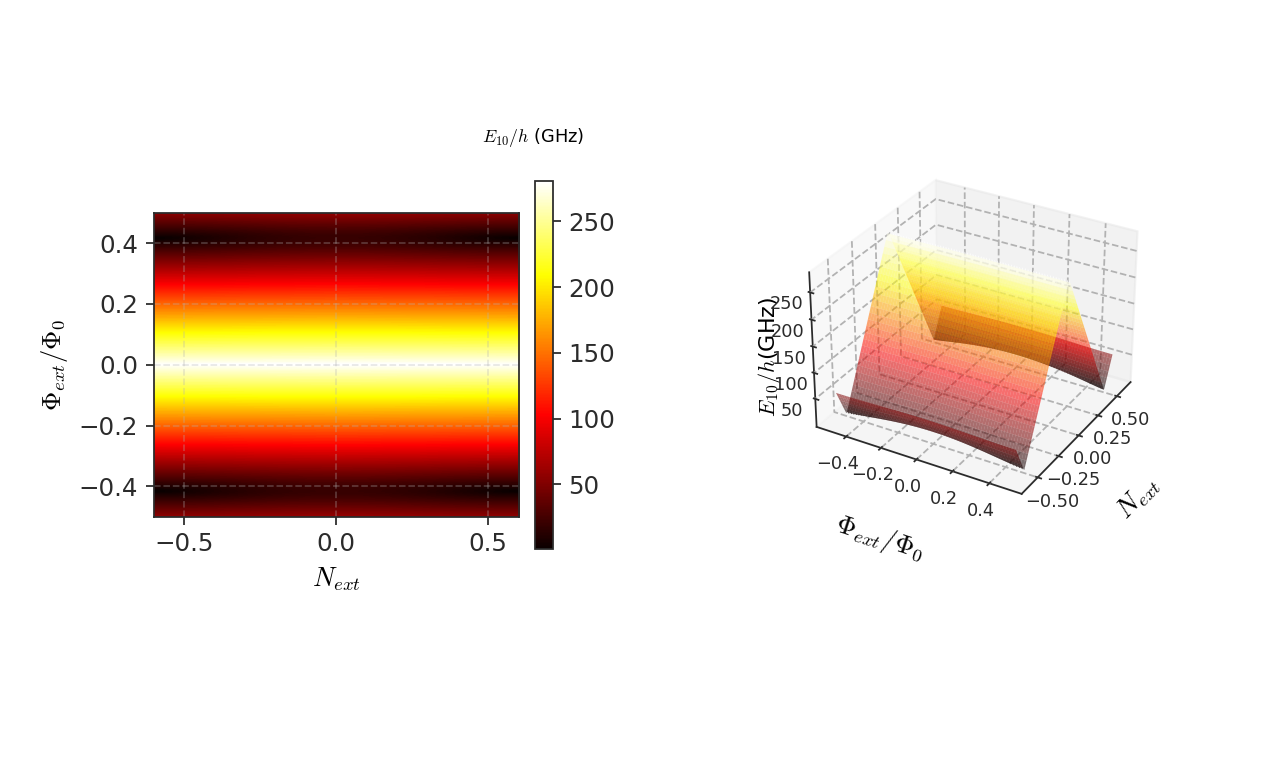

Text(10500, 0, '$E_{10}/h$(GHz)')

In [15]:
EC = 70
EJ0 = 10
transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
N_ext_list = np.linspace(-0.6, 0.6, 201)
flux_ext_list = np.linspace(-0.5, 0.5, 201)
number_of_levels_to_simulate = 3
use_sparse_matrix = False

simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

transition_01 = simulation["eigvals"][:,:,1] - simulation["eigvals"][:,:,0]

fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.12, bottom=None, right=0.9,
                     top=None, wspace=0.5, hspace=1)

ax_2d = fig.add_subplot(1, 2, 1)
im = ax_2d.imshow(
    transition_01,
    extent=[min(N_ext_list), max(N_ext_list), min(flux_ext_list), max(flux_ext_list)],
    origin='lower',
    cmap=cm.hot,
    interpolation='bessel',
)
# Annotation
cb = fig.colorbar(im, ax=ax_2d, fraction=0.046, pad=0.04)
cb.ax.set_ylabel(r"$E_{10}/h$ (GHz)", fontsize=8,
                 rotation=0, ha="left", labelpad=-60, y=1.15)
ax_2d.set_ylabel(r"$\Phi_{ext}/\Phi_0$", fontsize=12)
ax_2d.set_xlabel(r"$N_{ext}$", fontsize=12)

(x0, y0, width, height) = ax_2d.get_position().bounds
(w_pad, h_pad, wspace, hspace) = fig.get_constrained_layout_pads()
ax_3d = fig.add_axes([x0 + width + 7 * hspace, y0, width * 1.5, height * 1.2], projection='3d')
ax_3d.zaxis._axinfo['juggled'] = (1,2,1)

grid_x, grid_y = np.meshgrid(flux_ext_list, N_ext_list)
surf = ax_3d.plot_surface(grid_x, grid_y,
                          transition_01,
                          cmap=cm.hot,
                          ccount=100,
                          rcount=100,
                          alpha=0.55,
                          linewidth=0, antialiased=True, edgecolor='red'
                          )

# Annotation
# ax_3d.view_init(elev=32, azim=32)
ax_3d.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=12)
ax_3d.set_ylabel(r"$N_{ext}$", fontsize=12)
ax_3d.tick_params(axis='both', which='major', labelsize=8, pad=-2)
ax_3d.zaxis.set_rotate_label(False)
ax_3d.set_zlabel(r"$E_{10}/h$(GHz)", fontsize=10, rotation=90, labelpad=-10, x=10500)
# ax_3d.text(x0, y0 - width * 0.5, 55, r"$E_{10}/h$ (GHz)", color='black',fontsize=8)

# ax_3d.invert_xaxis()

## $\Phi_{ext}$  varied and $N_{ext}=0$

In [16]:
N_ext_list = [0.5]
flux_ext_list = np.linspace(-1.5, 1.5, 201)
number_of_levels_to_simulate = 2
use_sparse_matrix = False

EC = 70
EJ0 = 10
transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

simulation_1 = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

transmon_qubit_constant_manager:118:override_parameters
⮑  Overriding to the following values:
EC:       70
EJ0:      10


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



In [17]:
EC = 17.5
EJ0 = 10
N_ext_list = [0]
transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

simulation_2 = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

transmon_qubit_constant_manager:118:override_parameters
⮑  Overriding to the following values:
EC:       17.5
EJ0:      10


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


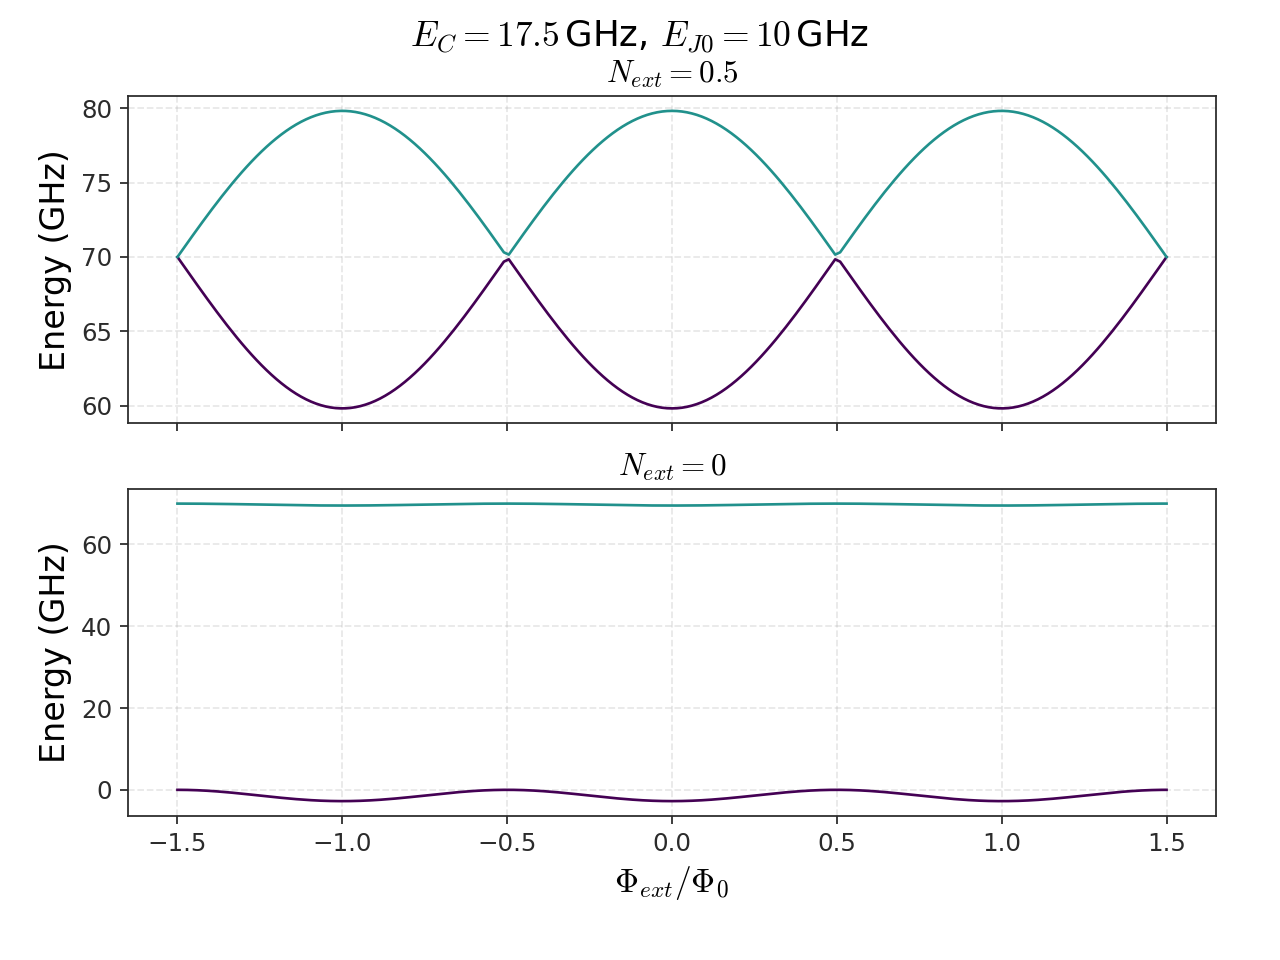

In [22]:
%matplotlib notebook

# 1 - plot simulation and spectrum
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for level in range(number_of_levels_to_simulate):
    ax[0].plot(flux_ext_list, simulation_1["eigvals"][0,:,level],
        color=COLORMAP_ENERGY(level / number_of_levels_to_simulate),
        linestyle="-")
    
for level in range(number_of_levels_to_simulate):
    ax[1].plot(flux_ext_list, simulation_2["eigvals"][0,:,level],
        color=COLORMAP_ENERGY(level / number_of_levels_to_simulate),
        linestyle="-")

fig.suptitle(f"$E_C={EC}\,$GHz, $E_{{J0}}=10\,$GHz", fontsize=16)
ax[0].set_title("$N_{ext}=0.5$", fontsize=14)
ax[1].set_title("$N_{ext}=0$", fontsize=14)
ax[0].set_ylabel("Energy (GHz)", fontsize=15)
ax[1].set_ylabel("Energy (GHz)", fontsize=15)
ax[1].set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/cooper-pair-box-as-a-function-of-phi-ext.pdf")

# Investigating different simulation regimes

## Low anharmonicity

transmon_qubit_constant_manager:129:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.33 (GHz)
EJ0:                                              82.36 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          20
jj_squares:                                       1
C_transmon:                                       56.00 (fF)
C_gate:                                           1.50 (fF)

-----Derived Parameters-----
C_jj:                                             0.51 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             58.52 (fF)
Critical Current:                                 0.17 (µA)
JJ Resistance:                                    1.84 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


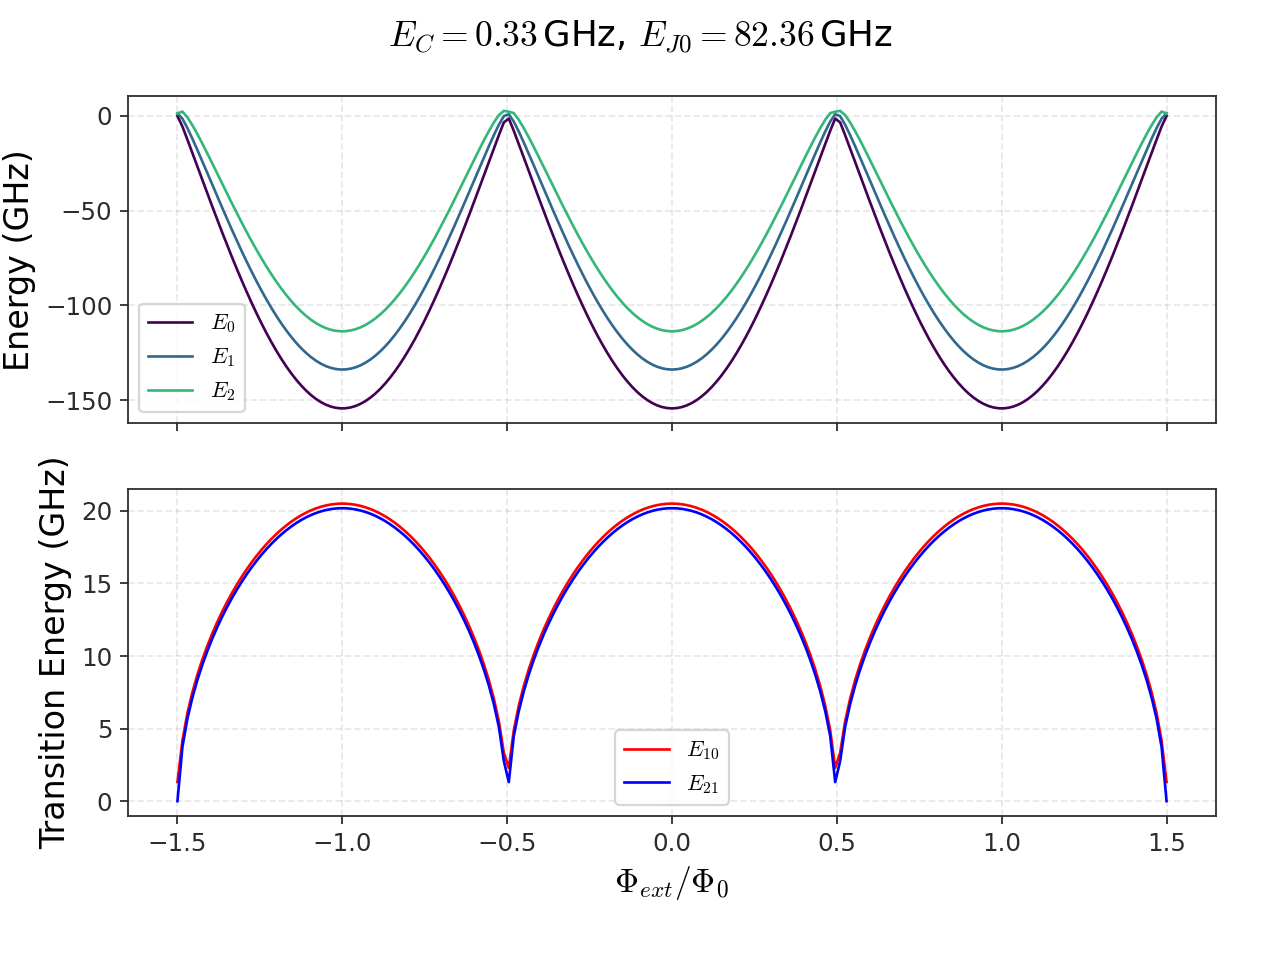

In [23]:
import logging
import numpy as np
from quantum_builder import QuantumBuilder

# Distances will be in µm
L_gate = 15
C_gate = (L_gate / 10) * fF

L_transmon = 150
S_transmon = 10
C_transmon = (4 * (L_transmon - S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": 1,
    "number_of_charge_states": 20,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

# Simulation
N_ext_list = [0]
flux_ext_list = np.linspace(-1.5, 1.5, 201)
number_of_levels_to_simulate = 3
use_sparse_matrix = False

simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

# Plot simulation and spectrum
transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for level in range(number_of_levels_to_simulate):
    ax[0].plot(flux_ext_list, simulation["eigvals"][0,:,level],
        color=COLORMAP_ENERGY(level / number_of_levels_to_simulate),
        linestyle="-", label=f"$E_{level}$")
    
ax[1].plot(flux_ext_list, transition01,
           color="red",
           linestyle="-",
           label="$E_{10}$"
          )
ax[1].plot(flux_ext_list, transition12,
           color="blue",
           linestyle="-",
           label="$E_{21}$"
          )

fig.suptitle(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz", fontsize=16)
ax[0].set_ylabel("Energy (GHz)", fontsize=15)
ax[0].legend()
ax[1].set_ylabel("Transition Energy (GHz)", fontsize=15)
ax[1].set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax[1].legend()

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/transmon-low-anharmonicity.pdf")

## High anharmonicity

transmon_qubit_constant_manager:129:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               1.67 (GHz)
EJ0:                                              164.72 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          15
jj_squares:                                       2
C_transmon:                                       8.00 (fF)
C_gate:                                           1.50 (fF)

-----Derived Parameters-----
C_jj:                                             1.02 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             11.54 (fF)
Critical Current:                                 0.33 (µA)
JJ Resistance:                                    0.92 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


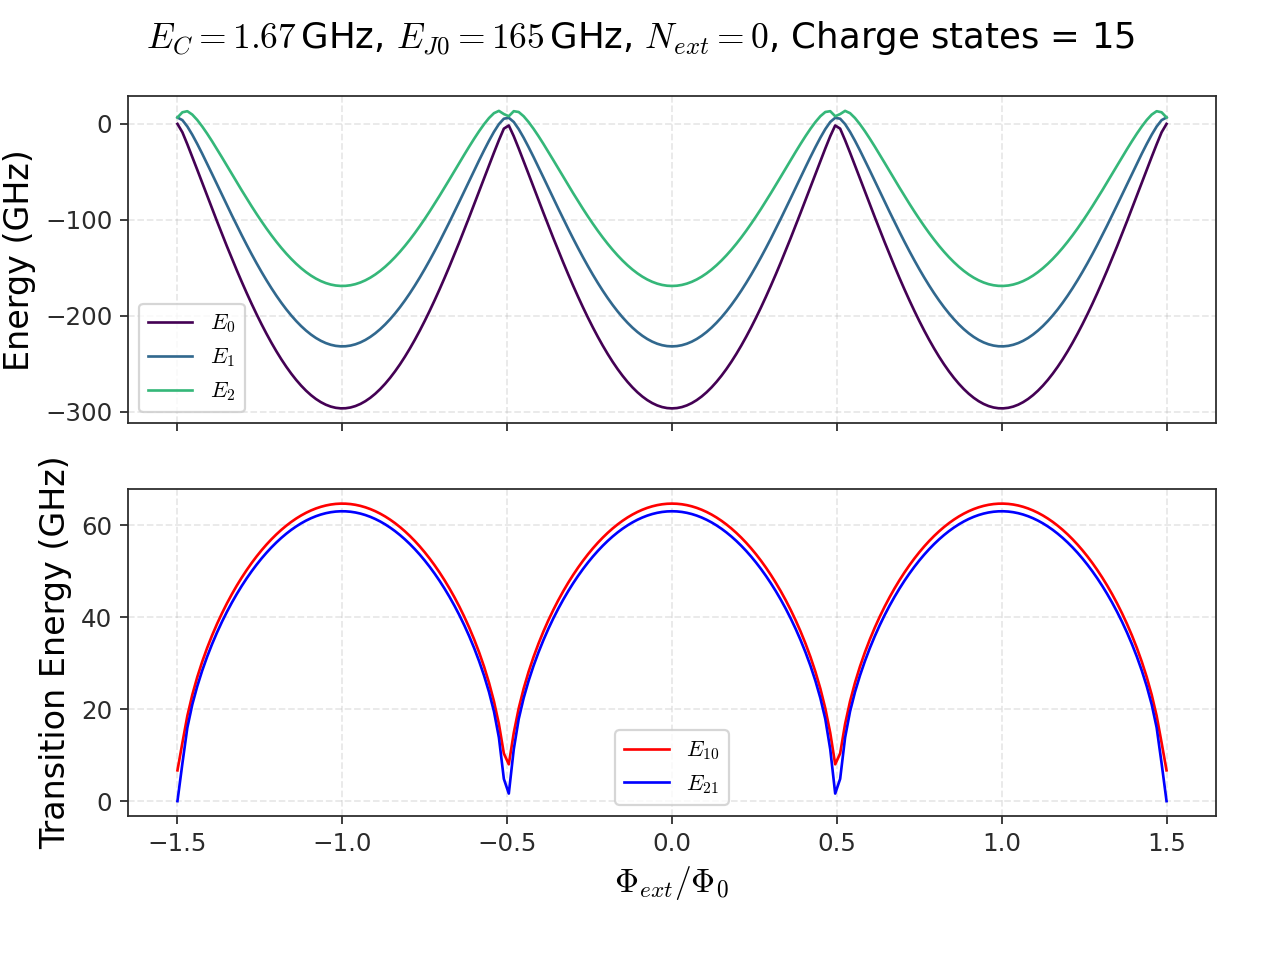

In [24]:
# Parameters
# Distances will be in µm
L_gate = 15
C_gate = (L_gate / 10) * fF

L_transmon = 30
S_transmon = 10
C_transmon = (4 * (L_transmon - S_transmon) / 10) * fF

N_ext_list = [0]
flux_ext_list = np.linspace(-1.5, 1.5, 201)
number_of_levels_to_simulate = 3
use_sparse_matrix = False
number_of_charge_states = 15

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": 2,
    "number_of_charge_states": number_of_charge_states,
}


# Simulation
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

# Plot simulation and spectrum
transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for level in range(number_of_levels_to_simulate):
    ax[0].plot(flux_ext_list, simulation["eigvals"][0,:,level],
        color=COLORMAP_ENERGY(level / number_of_levels_to_simulate),
        linestyle="-", label=f"$E_{level}$")
ax[1].plot(flux_ext_list, transition01,
           color="red",
           linestyle="-",
           label="$E_{10}$"
          )
ax[1].plot(flux_ext_list, transition12,
           color="blue",
           linestyle="-",
           label="$E_{21}$"
          )

fig.suptitle(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.0f}\,$GHz, $N_{{ext}} = {N_ext_list[0]}$, Charge states = {number_of_charge_states}", fontsize=16)
ax[0].set_ylabel("Energy (GHz)", fontsize=15)
ax[0].legend()
ax[1].set_ylabel("Transition Energy (GHz)", fontsize=15)
ax[1].set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax[1].legend()

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/transmon-with-parameters-from-geometry.pdf")

## Vary $N_{ext}$
Repeat simulations but for different $N_{ext}$ values

<IPython.core.display.Javascript object>


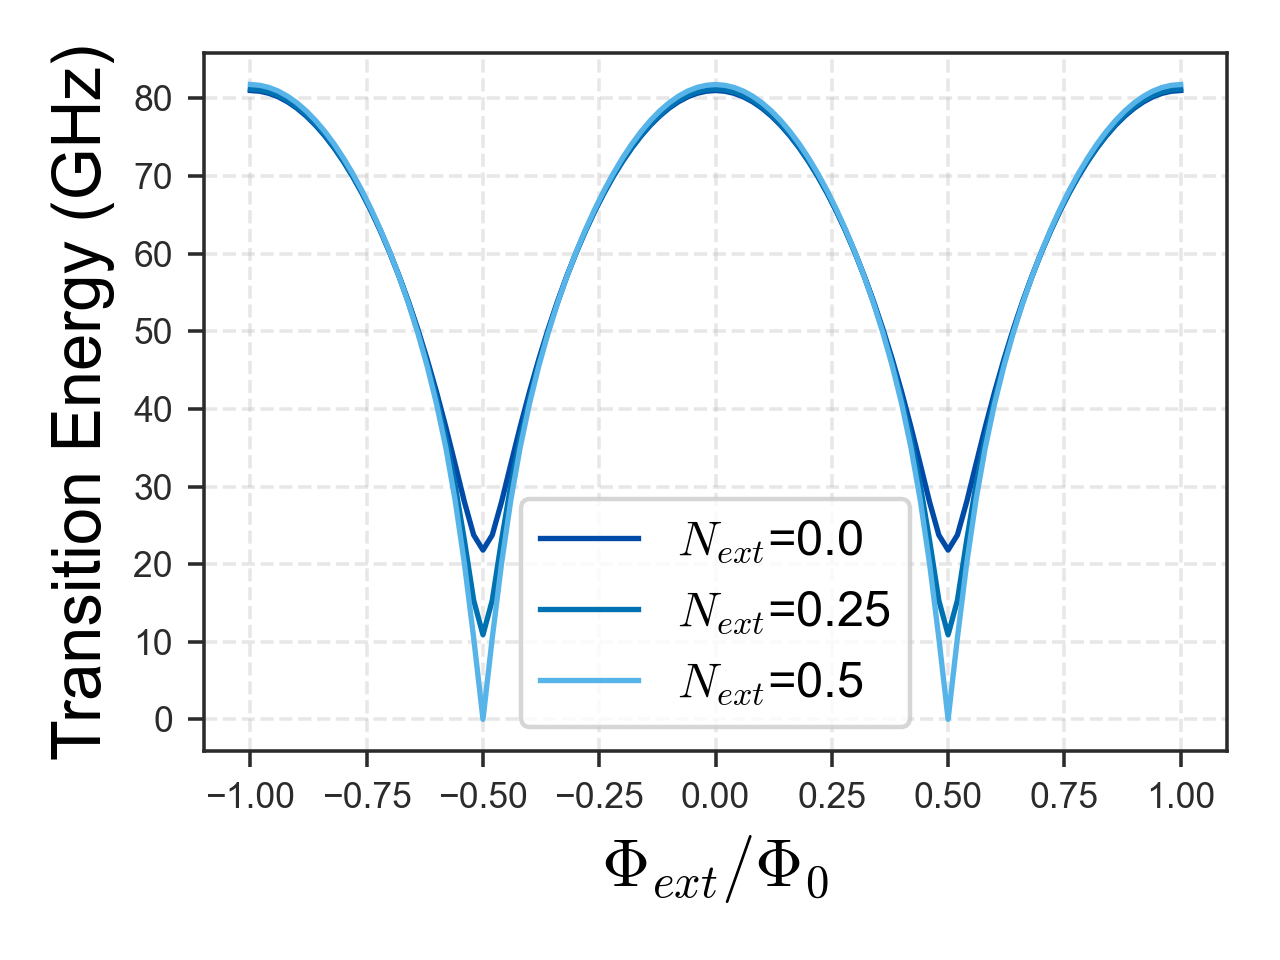

In [17]:
# Parameters
# Distances will be in µm
L_gate = 15
C_gate = (L_gate / 10) * fF

L_transmon = 10
S_transmon = 10
C_transmon = (4 * (L_transmon - S_transmon) / 10) * fF

N_ext_list = [0]
flux_ext_list = np.linspace(-1, 1, 101)
use_sparse_matrix = False
number_of_levels_to_simulate = 3
number_of_charge_states = 7

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
for N_ext in np.linspace(0, 0.5, 3):
    N_ext_list = [N_ext]
    
    QUBIT_PARAMETERS = {
        "C_gate": C_gate,
        "C_transmon": C_transmon,
        "jj_squares": 2,
        "number_of_charge_states": number_of_charge_states,
    }
    # Simulation
    transmon_qubit = QuantumBuilder.build_transmon_qubit(
        QUBIT_PARAMETERS, logging_level=logging.ERROR,
    )
    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=use_sparse_matrix)

    # Plot simulation and spectrum
    transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
    ax.plot(flux_ext_list, transition01,
               linestyle="-",
                label=f"$N_{{ext}}$={N_ext}"
              )

    
# ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, Number of charge states = {number_of_charge_states}", fontsize=16)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend()
plt.tight_layout()

plt.savefig("./output/transmon-sweep-N_ext.pdf")
# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/transmon-sweep-N_ext.png")

## Vary number of simulated states
- Let us investigate the effect of simulation with different number of states

**It seems that more states begins to converge on the correct answer, however more states will also tend to remove the anharmonicty of transitions**

<IPython.core.display.Javascript object>


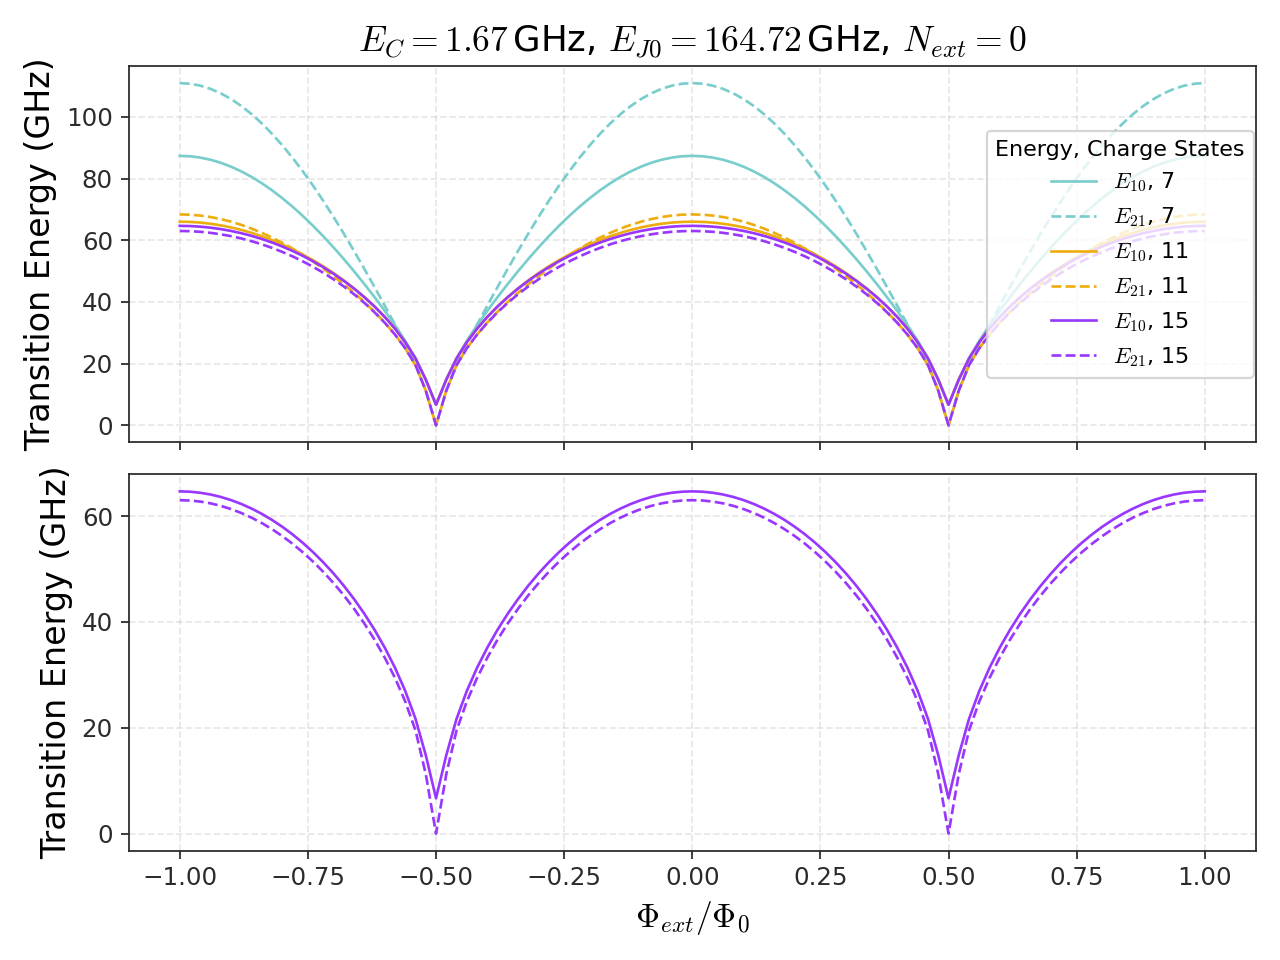

In [26]:
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')

# Parameters
# Distances will be in µm
L_gate = 15
C_gate = (L_gate / 10) * fF

L_transmon = 30
S_transmon = 10
C_transmon = (4 * (L_transmon - S_transmon) / 10) * fF

N_ext_list = [0]
flux_ext_list = np.linspace(-1, 1, 101)
use_sparse_matrix = False
number_of_levels_to_simulate = 3
number_of_charge_states_list = [7, 11, 15]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
for (idx, number_of_charge_states) in enumerate(number_of_charge_states_list):
    
    QUBIT_PARAMETERS = {
        "C_gate": C_gate,
        "C_transmon": C_transmon,
        "jj_squares": 2,
        "number_of_charge_states": number_of_charge_states,
    }
    # Simulation
    transmon_qubit = QuantumBuilder.build_transmon_qubit(
        QUBIT_PARAMETERS, logging_level=logging.ERROR,
    )
    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=use_sparse_matrix)

    # Plot simulation and spectrum
    transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
    transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]
    
    ax[0].plot(flux_ext_list, transition01,
               linestyle="-",
               color=COLORMAP_01[idx],
                label=f"$E_{{10}}$, {number_of_charge_states}"
              )
    ax[0].plot(flux_ext_list, transition12,
               linestyle="--",
               color=COLORMAP_01[idx],
                label=f"$E_{{21}}$, {number_of_charge_states}"
              )
    
    if idx == (len(number_of_charge_states_list) - 1):
        ax[1].plot(flux_ext_list, transition01,
               linestyle="-",
               color=COLORMAP_01[idx],
                label=f"$E_{{10}}$, {number_of_charge_states}"
              )
        ax[1].plot(flux_ext_list, transition12,
                   linestyle="--",
                   color=COLORMAP_01[idx],
                    label=f"$E_{{21}}$, {number_of_charge_states}"
                  )

ax[0].set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $N_{{ext}}={N_ext_list[0]}$", fontsize=16)
ax[0].set_ylabel("Transition Energy (GHz)", fontsize=15)
ax[1].set_ylabel("Transition Energy (GHz)", fontsize=15)
ax[1].set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax[0].legend(loc="center right",
           borderaxespad=0.1,
          title="Energy, Charge States")

plt.tight_layout()

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/transmon-sweep-number-of-charge-states.pdf")

# Digging for anharmonicity and charge dispersion
- We want to probe how the ratio $E_C/E_{J0}$ affects the transitions energy ratio
\begin{equation}
 \alpha = \frac{E_{21} - E_{10}}{E_{10}}.
\end{equation}

- We also want to look at charge dispersion

\begin{equation}
 \varepsilon_m = \frac{E_m(N_{ext}=0.5) - E_m(N_{ext}=0)}{E_{10}}
\end{equation}

transmon_qubit_constant_manager:129:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               9.55 (GHz)
EJ0:                                              82.36 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          15
jj_squares:                                       1
C_transmon:                                       1.00 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.51 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             2.02 (fF)
Critical Current:                                 0.17 (µA)
JJ Resistance:                                    1.84 (k𝛀)




<IPython.core.display.Javascript object>


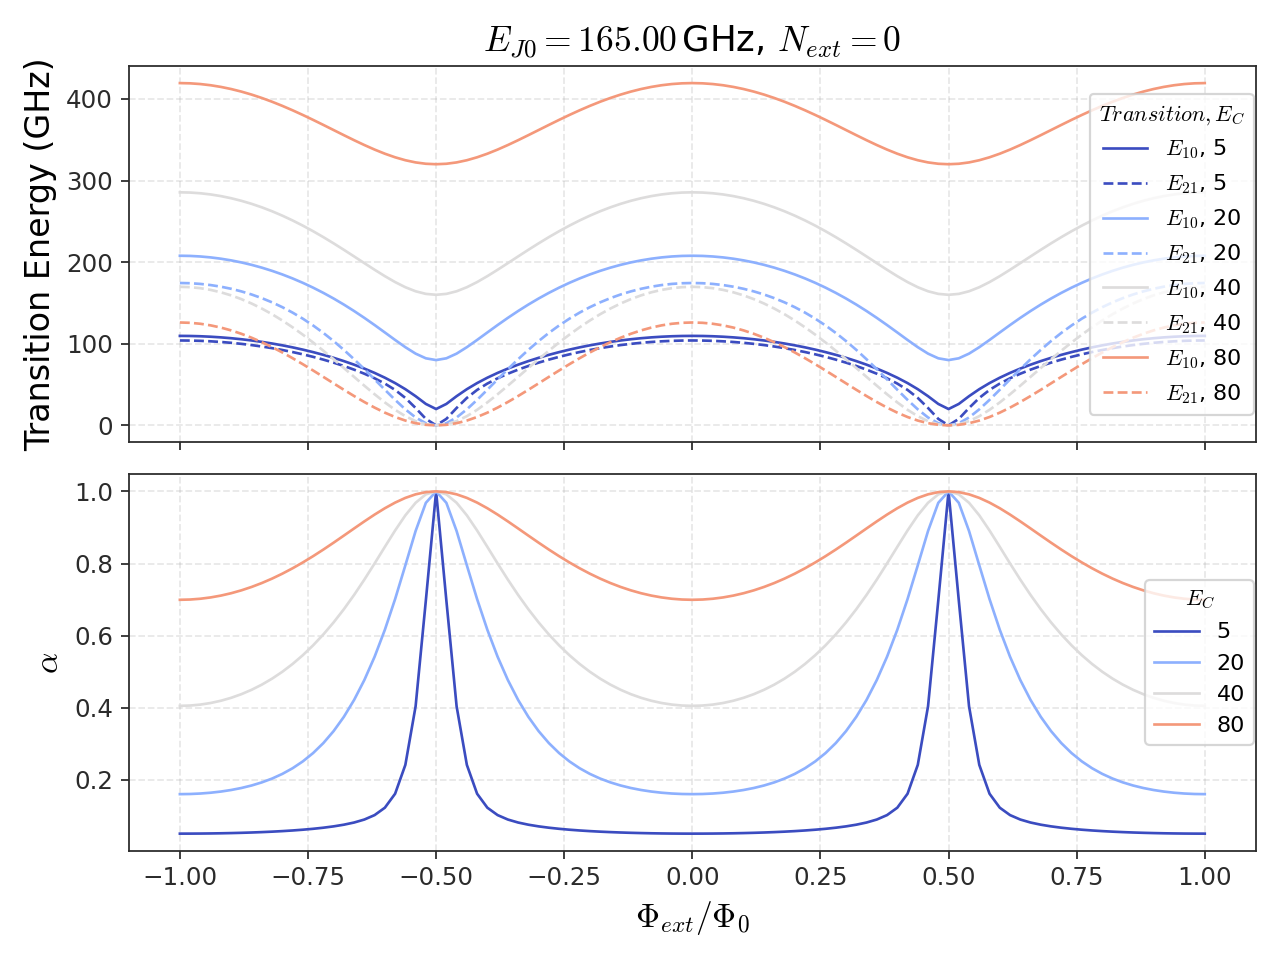

transmon_qubit_constant_manager:118:override_parameters
⮑  Overriding to the following values:
EC:       5
EJ0:      165


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:118:override_parameters
⮑  Overriding to the following values:
EC:       20
EJ0:      165


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:118:override_parameters
⮑  Overriding to the following values:
EC:       40
EJ0:      165


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:118:override_parameters
⮑  Overriding to the following values:
EC:       80
EJ0:      165


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



In [27]:
COLORMAP = plt.get_cmap('coolwarm')
COLORMAP12 = plt.get_cmap('hsv')

N_ext_list = [0.5]
flux_ext_list = np.linspace(-1, 1, 101)
number_of_levels_to_simulate = 3
use_sparse_matrix = False

EC_list = [5, 20, 40, 80]
EJ0 = 165
N_ext_list = [0]

QUBIT_PARAMETERS = {
    "C_gate": 0 * fF,
    "C_transmon": 1 * fF,
    "jj_squares": 1,
    "number_of_charge_states": 15,
}

transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for idx, EC in enumerate(EC_list):
    transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=use_sparse_matrix)
    # Plot simulation and spectrum
    transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
    transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]
    
    ax[0].plot(flux_ext_list, transition01,
               linestyle="-",
               color=COLORMAP(idx / len(EC_list)),
               label=f"$E_{{10}}$, {EC}"
              )
    ax[0].plot(flux_ext_list, transition12,
               linestyle="--",
               color=COLORMAP(idx / len(EC_list)),
               label=f"$E_{{21}}$, {EC}"
              )
    
    ax[1].plot(flux_ext_list, (transition01 - transition12) / transition01,
               linestyle="-",
               color=COLORMAP(idx / len(EC_list)),
                label=EC
              )

ax[0].set_title(f"$E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $N_{{ext}}={N_ext_list[0]}$", fontsize=16)
ax[0].set_ylabel("Transition Energy (GHz)", fontsize=15)
ax[1].set_ylabel(r"$\alpha$", fontsize=15)
ax[1].set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax[0].legend(loc="center right",
           borderaxespad=0.1,
          title="$Transition, E_C$")
ax[1].legend(loc="center right",
           borderaxespad=0.1,
          title="$E_C$")

plt.tight_layout()

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/transmon-anharmonicity.pdf")

## Now ignoring the specrum and just plotting:
\begin{equation}
 \alpha = \frac{E_{21} - E_{10}}{E_{10}}.
\end{equation}

and

\begin{equation}
 \varepsilon_m = \frac{E_m(N_{ext}=0.5) - E_m(N_{ext}=0)}{E_{10}}
\end{equation}

as a function of $E_C/E_{J0}$

<IPython.core.display.Javascript object>


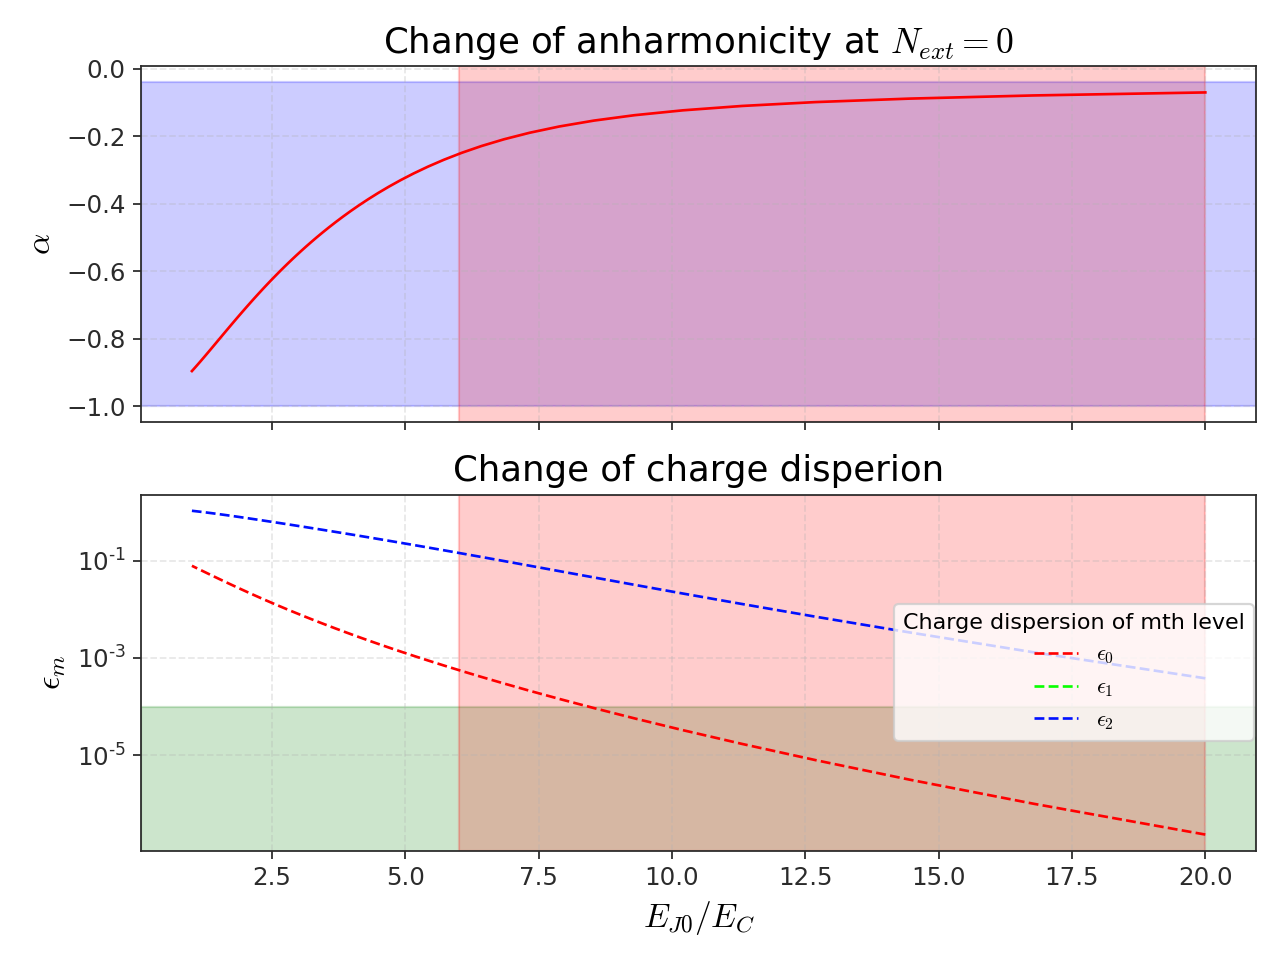

In [28]:
from collections import defaultdict
COLORMAP = plt.get_cmap('hsv')
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Init
N_ext_list = [0, 0.5]
Next0 = 0
Next05 = 1

flux_ext_list = [0]
number_of_levels_to_simulate = 3
use_sparse_matrix = False
EJ0 = 100
QUBIT_PARAMETERS = {
    "C_gate": 0 * fF,
    "C_transmon": 1 * fF,
    "jj_squares": 1,
    "number_of_charge_states": 100,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.WARNING,
)

# Traverse across EJ0/EC
EC_list = np.linspace(5, 100, 100)
(alpha_list, 
 EJ_EC_ratio_list, 
 charge_dispersion_dict) = ([], 
                            [], 
                            defaultdict(list))

for (idx, EC) in enumerate(EC_list):
    transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=use_sparse_matrix)
    
    # Unpack simualation (first index is next, flux_ext, level)
    transition01 = simulation["eigvals"][Next0,0,1] - simulation["eigvals"][Next0,0,0]
    transition12 = simulation["eigvals"][Next0,0,2] - simulation["eigvals"][Next0,0,1]
    
    EJ_EC_ratio_list.append(EJ0 / EC)
    alpha_list.append((transition12 - transition01) / transition01)
    for m in range(number_of_levels_to_simulate):
        charge_dispersion_dict[f"m={m}"].append((simulation["eigvals"][Next05,0,m] - simulation["eigvals"][Next0,0,m]) / transition01)
    
ax[0].plot(EJ_EC_ratio_list, alpha_list,
               linestyle="-",
               color="red",
              )
for idx, m in enumerate(range(number_of_levels_to_simulate)):
    ax[1].plot(EJ_EC_ratio_list, charge_dispersion_dict[f"m={m}"],
           linestyle="--",
           color=COLORMAP(idx / number_of_levels_to_simulate),
           label=f"$\epsilon_{m}$"
          )
    

ax[0].set_title(f"Change of anharmonicity at $N_{{ext}}={N_ext_list[0]}$", fontsize=16)
ax[1].set_title(f"Change of charge disperion", fontsize=16)
ax[0].set_ylabel(r"$\alpha$", fontsize=15)
ax[1].set_ylabel(r"$\epsilon_m$", fontsize=15)
ax[1].set_xlabel("$E_{J0}/E_C$", fontsize=15)
ax[1].legend(loc="center right",
           borderaxespad=0.1,
          title="Charge dispersion of mth level")
ax[1].axhspan(0, 0.0001, color='green', alpha=0.2)
ax[1].set_yscale('log')
ax[0].axhspan(-1, -0.04, color='blue', alpha=0.2)
ax[0].axvspan(6, 20, color='red', alpha=0.2)
ax[1].axvspan(6, 20, color='red', alpha=0.2)
plt.tight_layout()

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/transmon-anharmonicity-and-charge-dispersion.pdf")

# Simulation of suitable parameters
- Maintain  anharmonicity   $|\alpha|  \ge   0.04  $   by  taking $E_{J0}/E_C < 70$;
- Reduce the  charge  dispersion  $\varepsilon_m$ -  practically anything  that  fits  $E_{J0}/E_C  > 5$ will  be  more  than suitable;
- We   need   the   transition  energy   to   be   within   the 5-20 GHz  gap  that  our  laboratory  equipment  can register.

## Geometry for $E_C$

In [22]:
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

# Parameters - distances will be in µm
JJ_SQUARES = 1
# Gate - little effect
L_gate = 15
C_gate = (L_gate / 10) * fF

L_transmon_list = np.linspace(100, 350, 101)
EC_list = []
C_tranmson_list = []

for L_transmon in L_transmon_list:
    # Transmon capacitor - do not make it too big
    S_transmon = 24
    C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

    number_of_levels_to_simulate=3
    QUBIT_PARAMETERS = {
        "C_gate": 0,
        "C_transmon": C_transmon,
        "jj_squares": JJ_SQUARES,
        "number_of_charge_states": 11,
    }

    # Charge has little effect, so can simulate for 0 or 0.5 - no difference
    N_ext_list = [0, 0.5]
    NUM_FLUX_POINTS = 101
    MID_FLUX_POINT = (NUM_FLUX_POINTS - 1) // 2
    flux_ext_list = np.linspace(-1, 1, NUM_FLUX_POINTS)


    # Simulation
    transmon_qubit = QuantumBuilder.build_transmon_qubit(
        QUBIT_PARAMETERS, logging_level=logging.ERROR,
    )
    
    EC_list.append(transmon_qubit.transmon_qubit_constant_manager.EC)
    C_tranmson_list.append(transmon_qubit.transmon_qubit_constant_manager.C_transmon)
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
ax.plot(L_transmon_list, EC_list,
               linestyle="-",
              )    

ax.set_ylabel("$E_C$(GHz)", fontsize=15)
ax.set_xlabel("$L_{transmon}$", fontsize=15)

plt.tight_layout()
plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/EC-selection.pdf")
plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/EC-selection.png")

KeyboardInterrupt: 

## Geometry for $E_{J0}$

In [ ]:
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

# Parameters - distances will be in µm
JJ_SQUARES_list = np.linspace(0.1, 2, 11)
# Gate - little effect
L_gate = 15
C_gate = (L_gate / 10) * fF

EJ0_list = []
C_tranmson_list = []

for JJ_SQUARES in JJ_SQUARES_list:
    # Transmon capacitor - do not make it too big
    L_transmon = 100
    S_transmon = 10
    C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

    number_of_levels_to_simulate=3
    number_of_charge_states = 40
    QUBIT_PARAMETERS = {
        "C_gate": C_gate,
        "C_transmon": C_transmon,
        "jj_squares": JJ_SQUARES,
        "number_of_charge_states": number_of_charge_states,
    }

    # Charge has little effect, so can simulate for 0 or 0.5 - no difference
    N_ext_list = [0]
    NUM_FLUX_POINTS = 101
    MID_FLUX_POINT = (NUM_FLUX_POINTS - 1) // 2
    flux_ext_list = np.linspace(-1, 1, NUM_FLUX_POINTS)


    # Simulation
    transmon_qubit = QuantumBuilder.build_transmon_qubit(
        QUBIT_PARAMETERS, logging_level=logging.ERROR,
    )
    
    EJ0_list.append(transmon_qubit.transmon_qubit_constant_manager.EJ0)
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
ax.plot(JJ_SQUARES_list, EJ0_list,
               linestyle="-",
              )    

ax.set_ylabel("$E_{J0}$(GHz)", fontsize=15)
ax.set_xlabel("$N_{sq}$", fontsize=15)

plt.tight_layout()
plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/EJ0-selection.pdf")
plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/EJ0-selection.png")

## Selecting by fixing transmon size and picking $E_{J0}$
- From above, we will choose $E_C \approx$5GHz (for a decent transmon cross size of 50$\mu m$)

### My old design `tline-9.dwg`
- 150µm Transmon
- JJ 200nm x (200 - 500)nm

<IPython.core.display.Javascript object>


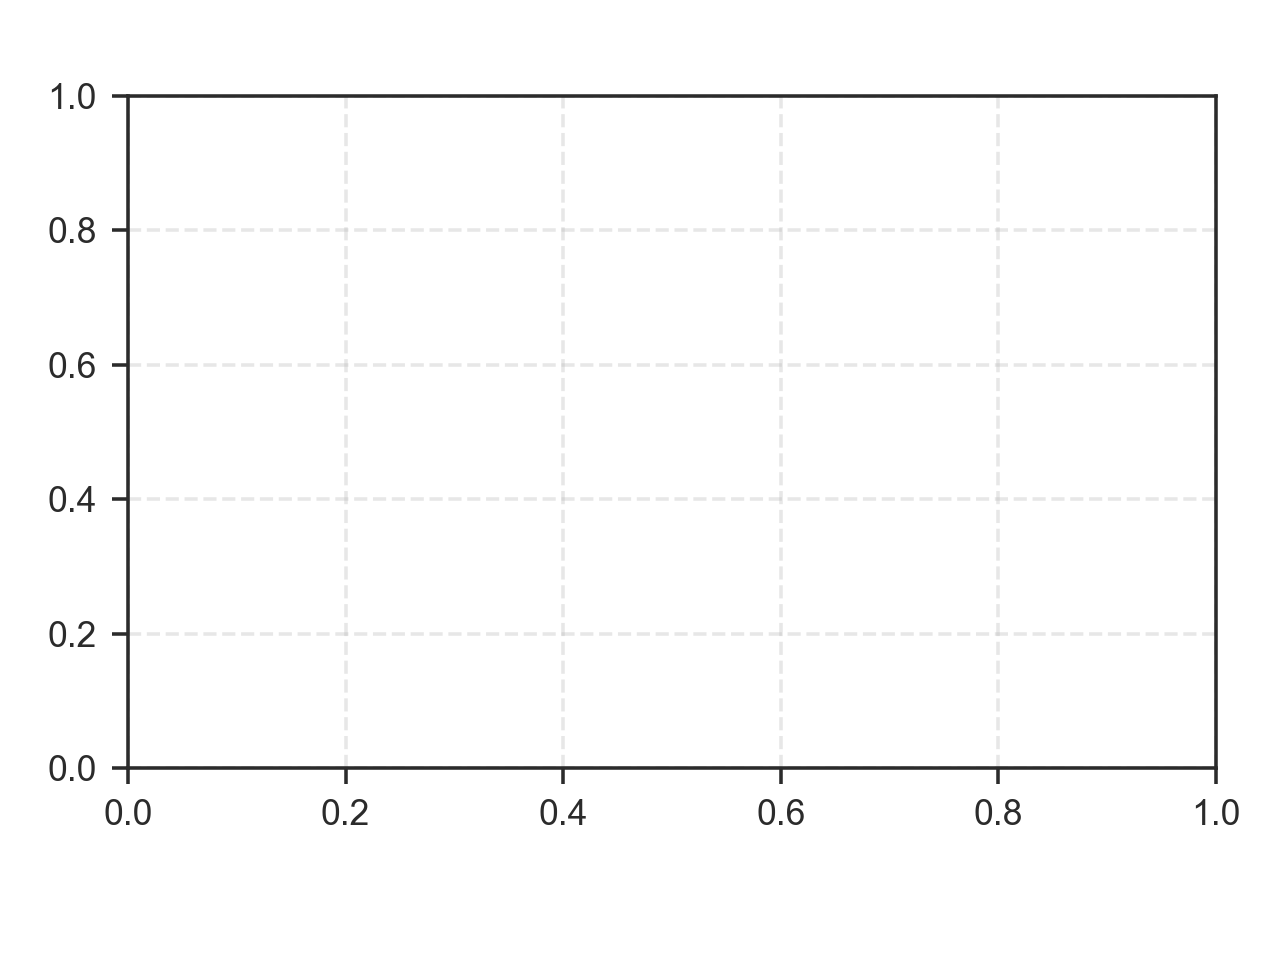

NameError: name 'transmon_qubit' is not defined

In [5]:
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('nipy_spectral')

QUBIT_PARAMETERS = {
        "C_gate": fF,
        "C_transmon": fF,
        "jj_squares": 1,
        "number_of_charge_states": 11,
    }
EC = 0.4
EJ0_list = [200, 400, 600, 800, 100]
N_ext_list = [0, 1]
NUM_FLUX_POINTS = 101
MID_FLUX_POINT = (NUM_FLUX_POINTS - 1) // 2
flux_ext_list = np.concatenate((np.linspace(-1, 1, NUM_FLUX_POINTS), np.linspace(1, 1.5, 10)))
# np.linspace(-1, 1, NUM_FLUX_POINTS)
number_of_levels_to_simulate = 3


fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
for (idx, EJ0) in enumerate(EJ0_list):
    transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=False)

    # Plot simulation and spectrum
    transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
    transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

    alpha =  (transition12[MID_FLUX_POINT] - transition01[MID_FLUX_POINT]) / transition01[MID_FLUX_POINT]
    linestyle="-"
    if (abs(alpha) < 0.04):
        linestyle = "--"
        
    Next05 = 1
    Next0 = 0
    charge_dispersion = (simulation["eigvals"][Next05,MID_FLUX_POINT,0] - simulation["eigvals"][Next0,MID_FLUX_POINT,0]) / transition01[MID_FLUX_POINT]
    if (abs(charge_dispersion) > 10**(-3)):
        linestyle = "--"
    
    ax.plot(flux_ext_list, transition01,
               linestyle=linestyle,
               color=COLORMAP_12(idx / len(EJ0_list)),
                label=f"{EJ0}, {alpha:.2f}, {charge_dispersion * 1000:.2f}"
              )
    
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}GHz$", fontsize=15)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(loc="center right",
           borderaxespad=0.1,
          title="$E_{J0},α,1000ɛ$",
#           title_fontsize=20,
#           fontsize=20
         )
ax.axhspan(2, 20, color='red', alpha=0.2)

plt.tight_layout()

plt.savefig("./output/selecting-EJ0-to-fall-in-range_EC=04GHz.pdf")
# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range_EC=04GHz.pdf")
# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range=04GHz.png")

### $E_C=5.0$ GHz

<IPython.core.display.Javascript object>


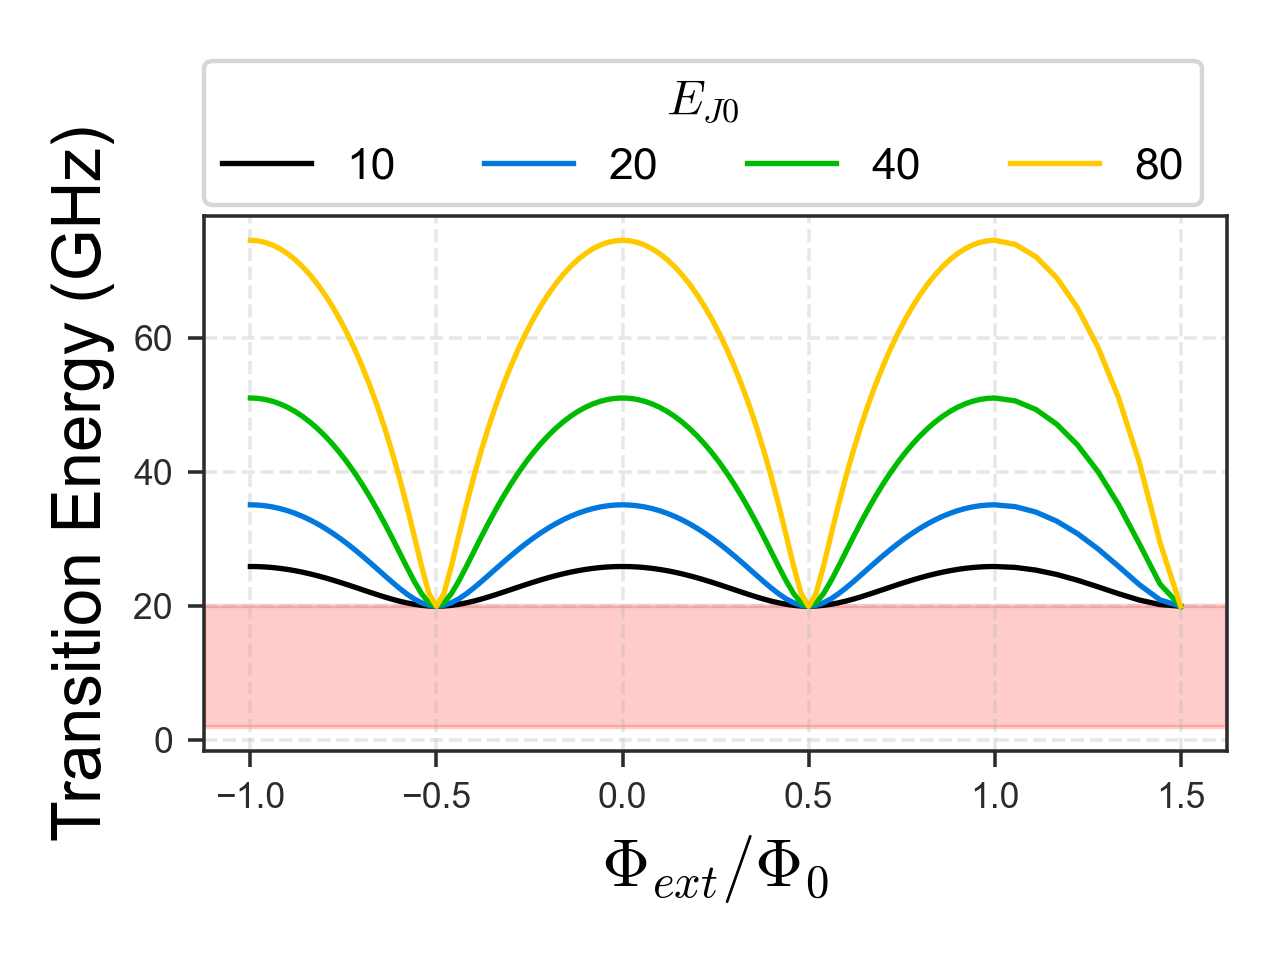

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       5
EJ0:      10


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       5
EJ0:      20


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       5
EJ0:      40


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       5
EJ0:      80


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



In [16]:
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('nipy_spectral')

QUBIT_PARAMETERS = {
        "C_gate": fF,
        "C_transmon": fF,
        "jj_squares": 1,
        "number_of_charge_states": 11,
    }
EC = 5
EJ0_list = [10, 20, 40, 80]
N_ext_list = [0, 0.5]
NUM_FLUX_POINTS = 101
MID_FLUX_POINT = (NUM_FLUX_POINTS - 1) // 2
flux_ext_list = np.concatenate((np.linspace(-1, 1, NUM_FLUX_POINTS), np.linspace(1, 1.5, 10)))
# np.linspace(-1, 1, NUM_FLUX_POINTS)
number_of_levels_to_simulate = 3


fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
for (idx, EJ0) in enumerate(EJ0_list):
    transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=False)

    # Plot simulation and spectrum
    transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
    transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

    alpha =  (transition12[MID_FLUX_POINT] - transition01[MID_FLUX_POINT]) / transition01[MID_FLUX_POINT]
    linestyle="-"
#     if (abs(alpha) < 0.04):
#         linestyle = "--"
        
    Next05 = 1
    Next0 = 0
    charge_dispersion = (simulation["eigvals"][Next05,MID_FLUX_POINT,0] - simulation["eigvals"][Next0,MID_FLUX_POINT,0]) / transition01[MID_FLUX_POINT]
#     if (abs(charge_dispersion) > 10**(-3)):
#         linestyle = "--"
    
    ax.plot(flux_ext_list, transition01,
               linestyle=linestyle,
               color=COLORMAP_12(idx / len(EJ0_list)),
            label=f"{EJ0}"
#                 label=f"{EJ0}, {alpha:.2f}, {charge_dispersion * 1000:.2f}"
              )
    
# ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}GHz$", fontsize=15)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(
           borderaxespad=0,
          title="$E_{J0}$",
         loc='lower left',
    bbox_to_anchor=(0, 1.02, 1,0.2), 
          ncol=4,
#           title_fontsize=20,
          fontsize=10
         )
ax.axhspan(2, 20, color='red', alpha=0.2)

plt.tight_layout()

plt.savefig("./output/electing-EJ0-to-fall-in-range_EC=5GHz.pdf")
# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range_EC=5GHz.pdf")
# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range=5GHz.png")

### $E_C=2.0$ GHz

<IPython.core.display.Javascript object>


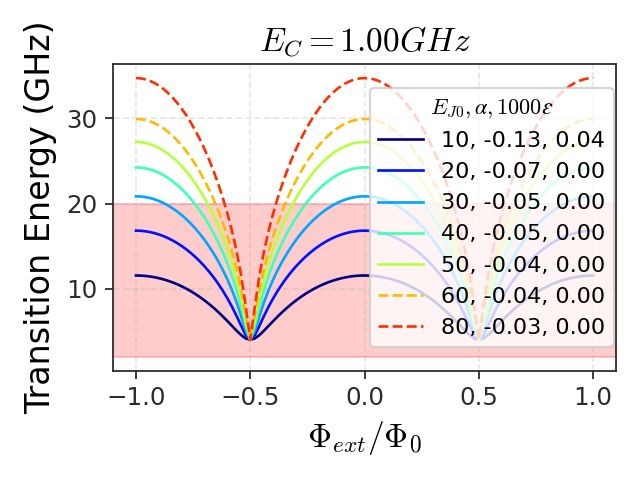

In [5]:
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('jet')

QUBIT_PARAMETERS = {
        "C_gate": fF,
        "C_transmon": fF,
        "jj_squares": 1,
        "number_of_charge_states": 3,
    }
EC = 1
EJ0_list = [10, 20, 30, 40, 50, 60, 80]
N_ext_list = [0, 0.5]
NUM_FLUX_POINTS = 101
MID_FLUX_POINT = (NUM_FLUX_POINTS - 1) // 2
flux_ext_list = np.linspace(-1, 1, NUM_FLUX_POINTS)
number_of_levels_to_simulate = 3


fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
for (idx, EJ0) in enumerate(EJ0_list):
    transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=False)

    # Plot simulation and spectrum
    transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
    transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

    alpha =  (transition12[MID_FLUX_POINT] - transition01[MID_FLUX_POINT]) / transition01[MID_FLUX_POINT]
    linestyle="-"
    if (abs(alpha) < 0.04):
        linestyle = "--"
    
    Next05 = 1
    Next0 = 0
    charge_dispersion = (simulation["eigvals"][Next05,MID_FLUX_POINT,0] - simulation["eigvals"][Next0,MID_FLUX_POINT,0]) / transition01[MID_FLUX_POINT]
    if (abs(charge_dispersion) > 10**(-3)):
        linestyle = "--"
    
    ax.plot(flux_ext_list, transition01,
               linestyle=linestyle,
               color=COLORMAP_12(idx / len(EJ0_list)),
                label=f"{EJ0}, {alpha:.2f}, {charge_dispersion * 1000:.2f}"
              )
    
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}GHz$", fontsize=15)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(loc="center right",
           borderaxespad=0.1,
          title="$E_{J0},α,1000ɛ$",
#           title_fontsize=20,
#           fontsize=20
         )
ax.axhspan(2, 20, color='red', alpha=0.2)
    
plt.tight_layout()

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range_EC=2GHz.pdf")
plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range_EC=2GHz.png")

### $E_C=0.2$ GHz

<IPython.core.display.Javascript object>


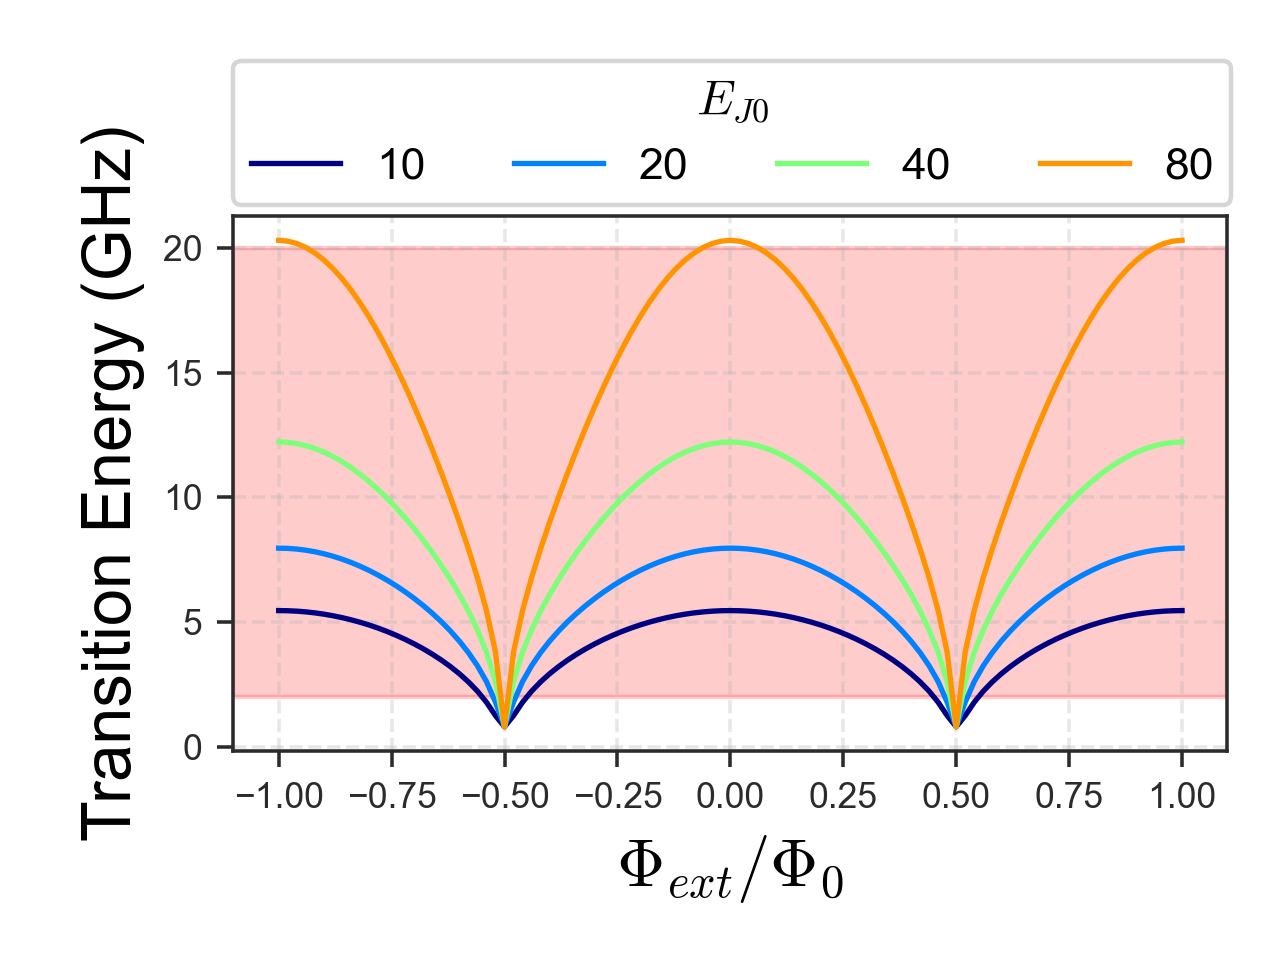

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       0.2
EJ0:      10


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       0.2
EJ0:      20


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       0.2
EJ0:      40


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed

transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       0.2
EJ0:      80


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



In [15]:
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('jet')

QUBIT_PARAMETERS = {
        "C_gate": fF,
        "C_transmon": fF,
        "jj_squares": 1,
        "number_of_charge_states": 3,
    }
EC = 0.2
EJ0_list = [10, 20, 40, 80]
N_ext_list = [0, 0.5]
NUM_FLUX_POINTS = 101
MID_FLUX_POINT = (NUM_FLUX_POINTS - 1) // 2
flux_ext_list = np.linspace(-1, 1, NUM_FLUX_POINTS)
number_of_levels_to_simulate = 3


fig, ax = plt.subplots(1, 1, figsize=(4,3), sharex=True)
for (idx, EJ0) in enumerate(EJ0_list):
    transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)
    simulation = transmon_qubit.transmon_qubit_simulator.simulate(
        N_ext_list=N_ext_list, 
        flux_ext_list=flux_ext_list, 
        number_of_levels_to_simulate=number_of_levels_to_simulate, 
        use_sparse_matrix=False)

    # Plot simulation and spectrum
    transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
    transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

    alpha =  (transition12[MID_FLUX_POINT] - transition01[MID_FLUX_POINT]) / transition01[MID_FLUX_POINT]
    linestyle="-"
#     if (abs(alpha) < 0.04):
#         linestyle = "--"
    
    Next05 = 1
    Next0 = 0
    charge_dispersion = (simulation["eigvals"][Next05,MID_FLUX_POINT,0] - simulation["eigvals"][Next0,MID_FLUX_POINT,0]) / transition01[MID_FLUX_POINT]
#     if (abs(charge_dispersion) > 10**(-3)):
#         linestyle = "--"
    
    ax.plot(flux_ext_list, transition01,
               linestyle=linestyle,
               color=COLORMAP_12(idx / len(EJ0_list)),
            label=f"{EJ0}"
#                 label=f"{EJ0}, {alpha:.2f}, {charge_dispersion * 1000:.2f}"
              )
    
# ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}GHz$", fontsize=15)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(
           borderaxespad=0,
          title="$E_{J0}$",
          loc='lower left',
    bbox_to_anchor=(0, 1.02, 1,0.2), 
          ncol=4,
#           title_fontsize=20,
          fontsize=10
         )
ax.axhspan(2, 20, color='red', alpha=0.2)

plt.tight_layout()

plt.savefig("./output/selecting-EJ0-to-fall-in-range_EC=0.2GHz.pdf")
# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range_EC=1GHz.pdf")
# plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/selecting-EJ0-to-fall-in-range_EC=1GHz.png")

## Interactive
Here we gix the size of the large capacitor, and see what $E_{J0}$ is needed. We will use it below.

- Trying to get into the 6-12GHz operating range of our components

<IPython.core.display.Javascript object>


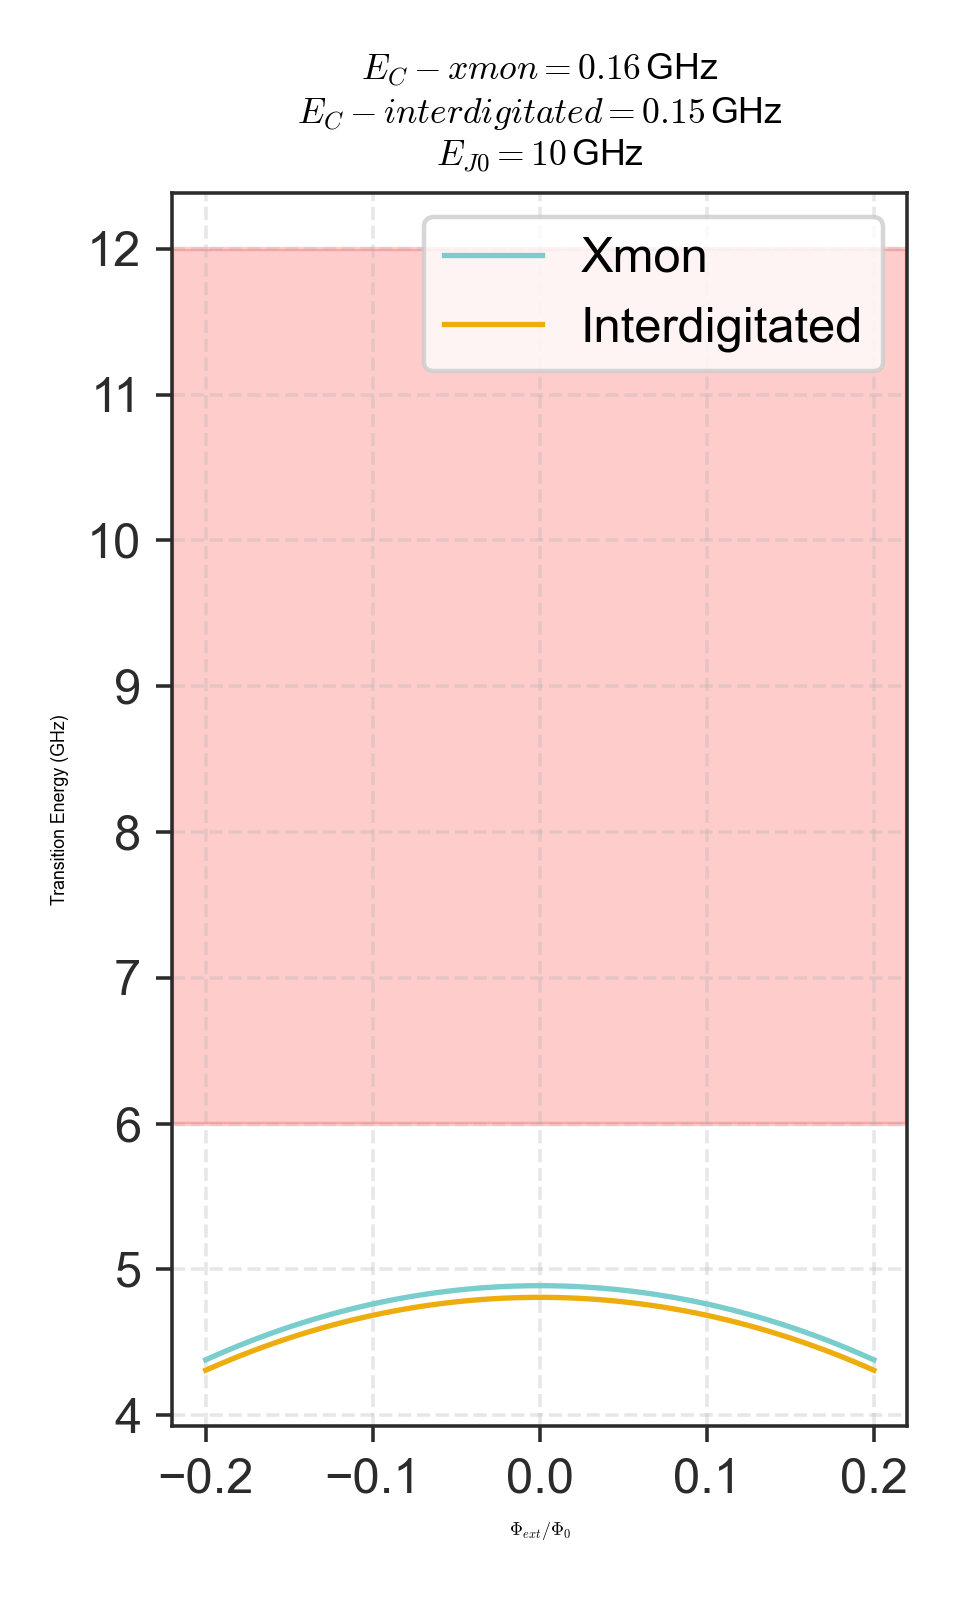

In [138]:
# For Interdigitated
L_int = 40*um
W_int = 10*um
N_int = 25

# For Xmon
L_transmon = 350
S_transmon = 24

# Derived parameters and initial values
EJ0 = 10
FLUX_LIST = np.linspace(-0.2, 0.2, 101)
EC_xmon = ec_xmon(S_transmon, L_transmon)
EC_intdig = ec_interdigitated(L_int, W_int, N_int)

xmon = scq.TunableTransmon(
    EJmax=2 * EJ0, EC=EC_xmon,
    d=0, flux=0.0, ng=0.0, ncut=21)
intdig = scq.TunableTransmon(
    EJmax=2 * EJ0, EC=EC_intdig,
    d=0, flux=0.0, ng=0.0, ncut=21
)
xmon_01 = xmon.get_spectrum_vs_paramvals(param_name='flux',
                                         param_vals=FLUX_LIST,
                                         evals_count=2,
                                         subtract_ground=True
                                         ).energy_table[:, 1]
intdig_01 = intdig.get_spectrum_vs_paramvals(param_name='flux',
                                             param_vals=FLUX_LIST,
                                             evals_count=2,
                                             subtract_ground=True
                                             ).energy_table[:, 1]

# Plot simulation and spectrum
fig, ax = plt.subplots(1, 1, figsize=(3, 5), sharex=True)

xmon_plot, = ax.plot(FLUX_LIST, xmon_01,
        linestyle="-", color=COLORMAP_01[0], label="Xmon"
        )
intdig_plot, = ax.plot(FLUX_LIST, intdig_01,
        linestyle="-", color=COLORMAP_01[1], label="Interdigitated"
        )

ax.set_title(
    f"$E_C-xmon={EC_xmon:.2f}\,$GHz" + "\n" +
    f"$E_C-interdigitated={EC_intdig:.2f}\,$GHz" + "\n" +
    f"$E_{{J0}} = {EJ0}\,$GHz", fontsize=8)
ax.set_ylabel("Transition Energy (GHz)", fontsize=4)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=4)
ax.legend()
ax.axhspan(6, 12, color='red', alpha=0.2)

plt.tight_layout()

In [98]:
def update(EJ0):
    xmon = scq.TunableTransmon(
        EJmax=2 * EJ0,
        EC=EC_xmon,
        d=0,       # no assymerty
        flux=0.0,  # defaults
        ng=0.0,
        ncut=21
    )
    intdig = scq.TunableTransmon(
        EJmax=2 * EJ0,
        EC=EC_intdig,
        d=0,       # no assymerty
        flux=0.0,  # defaults
        ng=0.0,
        ncut=21
    )
    xmon_01 = xmon.get_spectrum_vs_paramvals(param_name='flux',
                                             param_vals=FLUX_LIST,
                                             evals_count=2,
                                             subtract_ground=True
                                             ).energy_table[:, 1]
    intdig_01 = intdig.get_spectrum_vs_paramvals(param_name='flux',
                                                 param_vals=FLUX_LIST,
                                                 evals_count=2,
                                                 subtract_ground=True
                                                ).energy_table[:, 1]
    xmon_plot.set_ydata(xmon_01)
    intdig_plot.set_ydata(intdig_01)
    ax.set_title(
        f"$E_C-xmon={EC_xmon:.2f}\,$GHz" + "\n" +
        f"$E_C-interdigitated={EC_intdig:.2f}\,$GHz" + "\n" +
        f"$E_{{J0}} = {EJ0}\,$GHz", fontsize=8)
    
EJ0_widget = ipywidgets.FloatSlider(
    min=1, max=100, step=0.1,
    description="$E_{J0}$", value=EJ0,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=False
)

ui = ipywidgets.VBox([EJ0_widget])
out = ipywidgets.interactive_output(
    update,
    {
        "EJ0": EJ0_widget
    }
)
display(ui, out)

Output()

# Final qubits

## 2021-07 Photon source to fall in band of the IQ mixer
For the xmon iteself, we will use
- Xmon with 350 x 24 crosses
- Interdigitated with 40um x 10um x 25 fingers

For the JJ, we want to keep them 100nm x 100nm ideally and allow over-underoxidation, but so that EJ still falls in 20-40GHz range
- We will go for 0.1mbar oxidation
- 110nm x 110nm

<IPython.core.display.Javascript object>


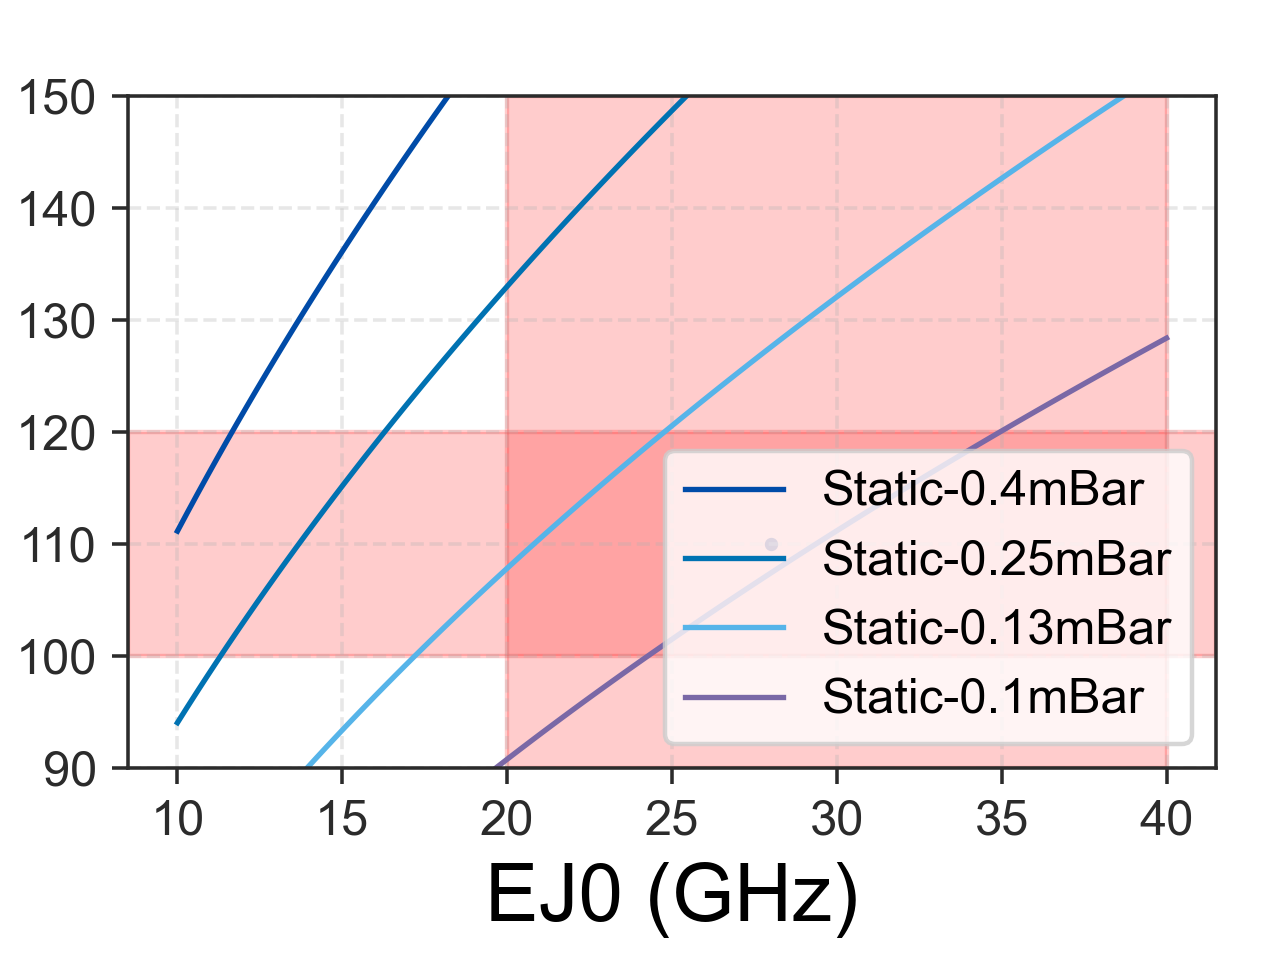

In [109]:
# First we figure out the number of JJ squares we would need under different oxidation conditions
OXIDATIONS = [
#     'Dynamic-20sccm',
    'Static-0.4mBar',
    'Static-0.25mBar',
    'Static-0.13mBar',
    'Static-0.1mBar',
]
EJ0_targets = np.linspace(10, 40, 101)

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)
ax.set_xlabel("EJ0 (GHz)")
ax.set_ylabel("JJ side (nm)")
ax.axhspan(100, 120, color='red', alpha=0.2)
ax.axvspan(20, 40, color='red', alpha=0.2)
ax.set_ylim([90, 150])

# Mark the target
ax.scatter([28], [110])

for o in OXIDATIONS:
    jj_side = [100 * np.sqrt(evaluating_n_squares(EJ0, o)) for EJ0 in EJ0_targets]
#     jj_side = [100 * evaluating_n_squares(EJ0, o) for EJ0 in EJ0_targets]
    ax.plot(EJ0_targets, jj_side, label=o)
    
ax.legend()    

In [117]:
EJ0_target = 25
oxidation = 'Static-0.1mBar'

n_squares = evaluating_n_squares(EJ0_target, oxidation)
size = np.sqrt(n_squares)
print(f"{oxidation}" + "\t\t" + f"{n_squares:.2f} squares\t\t" + f"x={size / JJ_x_scaling:.2f}, y={size / JJ_y_scaling:.2f}")

Static-0.1mBar		1.03 squares		x=0.98, y=0.97


<IPython.core.display.Javascript object>


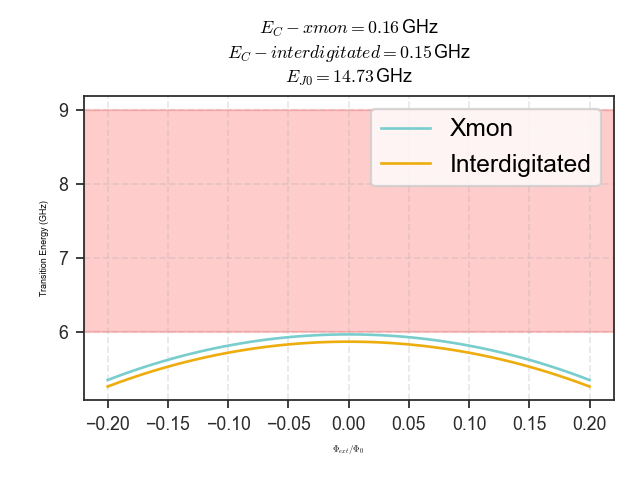

In [2]:
# Final Design Simulation
oxidation = 'Static-0.1mBar'
# oxidation = 'Static-0.4mBar'
jj_size = 100

# For Interdigitated
L_int = 40*um
W_int = 10*um
N_int = 25

# For Xmon
L_transmon = 350
S_transmon = 24

# Derived parameters and initial values
EJ0 = eval_expected_ej0(jj_size, oxidation)
EC_xmon = ec_xmon(S_transmon, L_transmon)
EC_intdig = ec_interdigitated(L_int, W_int, N_int)
FLUX_LIST = np.linspace(-0.2, 0.2, 101)

xmon = scq.TunableTransmon(
    EJmax=2 * EJ0, EC=EC_xmon,
    d=0, flux=0.0, ng=0.0, ncut=21)
intdig = scq.TunableTransmon(
    EJmax=2 * EJ0, EC=EC_intdig,
    d=0, flux=0.0, ng=0.0, ncut=21
)
xmon_01 = xmon.get_spectrum_vs_paramvals(param_name='flux',
                                         param_vals=FLUX_LIST,
                                         evals_count=2,
                                         subtract_ground=True
                                         ).energy_table[:, 1]
intdig_01 = intdig.get_spectrum_vs_paramvals(param_name='flux',
                                             param_vals=FLUX_LIST,
                                             evals_count=2,
                                             subtract_ground=True
                                             ).energy_table[:, 1]

# Plot simulation and spectrum
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True)

xmon_plot, = ax.plot(FLUX_LIST, xmon_01,
        linestyle="-", color=COLORMAP_01[0], label="Xmon"
        )
intdig_plot, = ax.plot(FLUX_LIST, intdig_01,
        linestyle="-", color=COLORMAP_01[1], label="Interdigitated"
        )

ax.set_title(
    f"$E_C-xmon={EC_xmon:.2f}\,$GHz" + "\n" +
    f"$E_C-interdigitated={EC_intdig:.2f}\,$GHz" + "\n" +
    f"$E_{{J0}} = {EJ0:.2f}\,$GHz", fontsize=8)
ax.set_ylabel("Transition Energy (GHz)", fontsize=4)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=4)
ax.legend()
ax.axhspan(6, 9, color='red', alpha=0.2)

plt.tight_layout()

## Artems geometry
- Transmon size = 350$\mu$m
- JJ size $\sim 100 \times 100 \text{nm}^2$

<IPython.core.display.Javascript object>


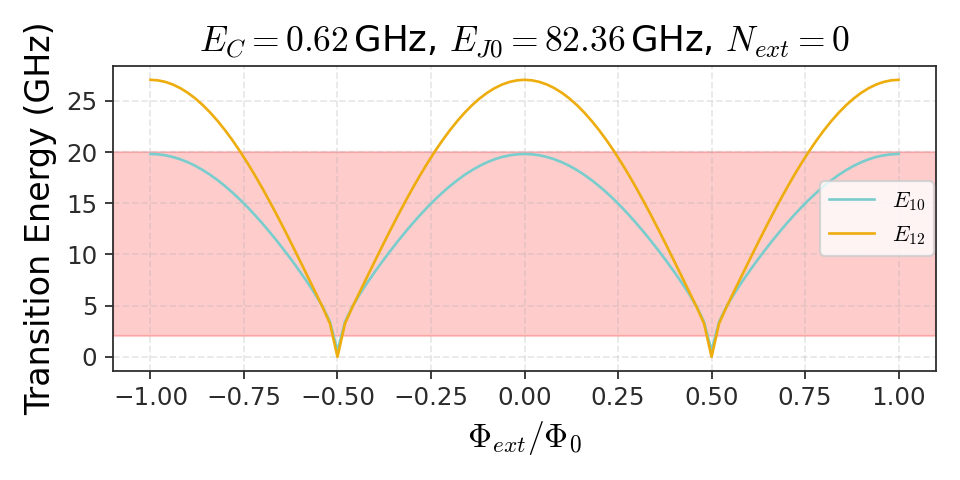

In [11]:

# Geometrical Parameters
# Distances will be in µm
L_gate = 30
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

no_100x100_jj_squares = 1

QUBIT_PARAMETERS = {
        "C_gate": C_gate,
        "C_transmon": C_transmon,
        "jj_squares": no_100x100_jj_squares,
        "number_of_charge_states": 11,
    }

# Simulation parameters
N_ext_list = [0]
flux_ext_list = np.linspace(-1, 1, 101)
use_sparse_matrix = False
number_of_levels_to_simulate = 3

# Simulation
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.ERROR,
)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list, 
    number_of_levels_to_simulate=number_of_levels_to_simulate, 
    use_sparse_matrix=use_sparse_matrix)

# Plot simulation and spectrum
fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]
transition12 = simulation["eigvals"][0,:,2] - simulation["eigvals"][0,:,1]

ax.plot(flux_ext_list, transition01,
           linestyle="-",
           color=COLORMAP_01[0],
           label="$E_{10}$"
          )
ax.plot(flux_ext_list, transition12,
           linestyle="-",
           color=COLORMAP_01[1],
           label="$E_{12}$"
          )

ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $N_{{ext}}={N_ext_list[0]}$", fontsize=16)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(loc="center right",
           borderaxespad=0.1)
ax.axhspan(2, 20, color='red', alpha=0.2)

plt.tight_layout()

plt.savefig("./output/2020-09-05_(cooper-pair-box-and-transmon)/final-qubit-design_artem.pdf")

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.15 (GHz)
EJ0:                                              42.45 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          11
jj_squares:                                       1.00 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           3.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.51 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             124.82 (fF)
Critical Current:                                 0.09 (µA)
JJ Resistance:                                    3.57 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


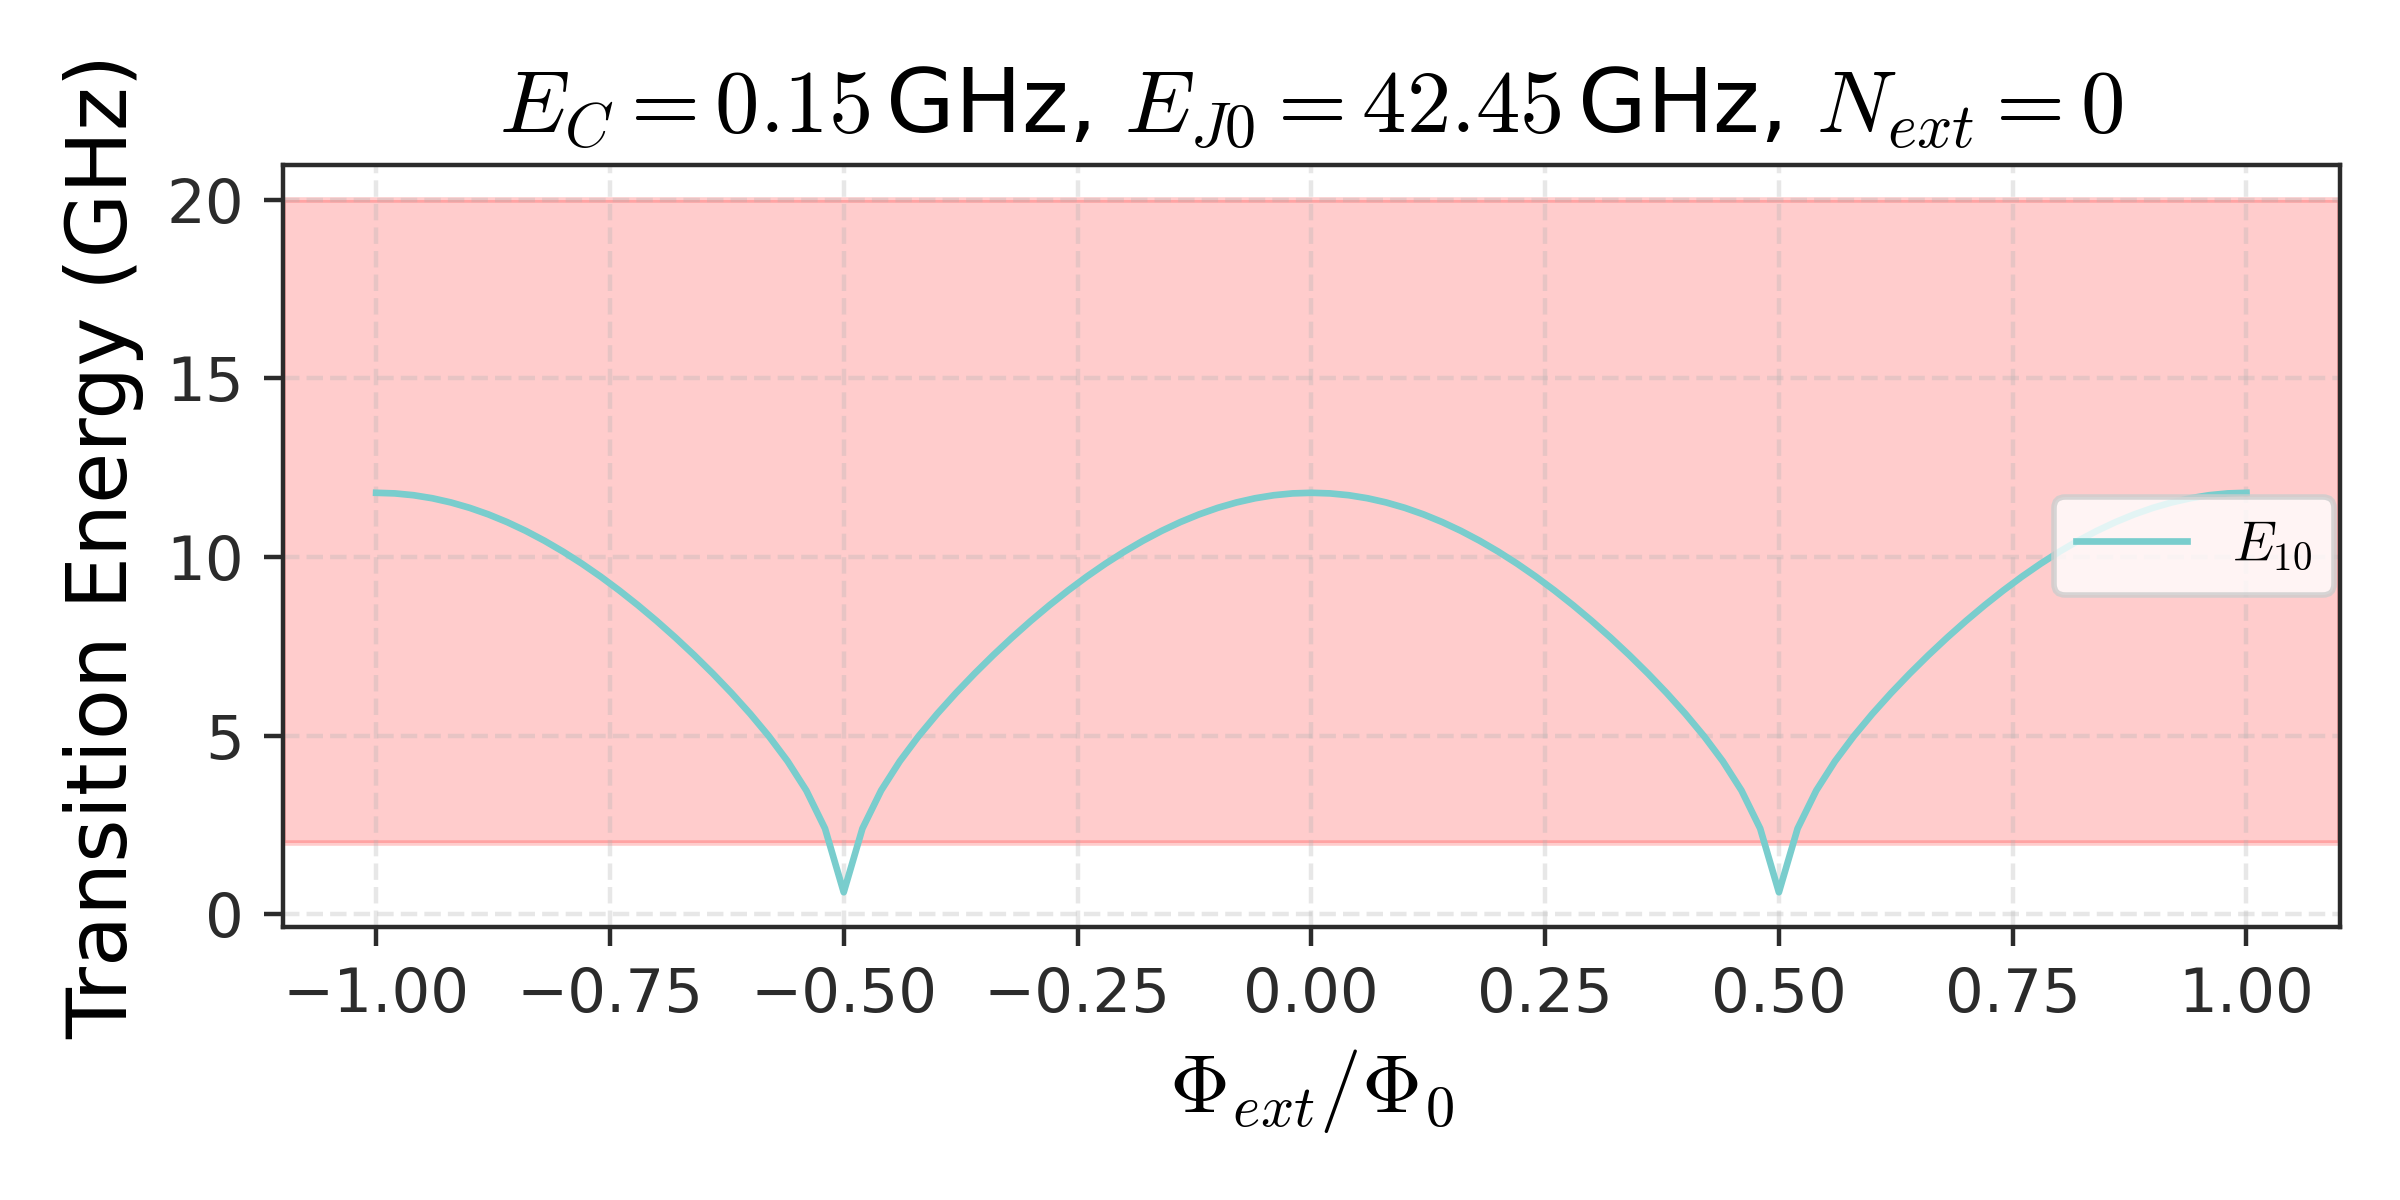

In [3]:
# Geometrical Parameters
# Distances will be in µm
L_gate = 30
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

no_100x100_jj_squares = 1

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 11,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

N_ext_list = [0]
flux_ext_list = np.linspace(-1, 1, 101)

transmon_qubit.over

simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3, 
    use_sparse_matrix=False)



# Plot simulation and spectrum
fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]

ax.plot(flux_ext_list, transition01,
           linestyle="-",
           color=COLORMAP_01[0],
           label="$E_{10}$"
          )
# ax.plot(flux_ext_list, transition12,
#            linestyle="-",
#            color=COLORMAP_01[1],
#            label="$E_{12}$"
#           )

ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $N_{{ext}}={N_ext_list[0]}$", fontsize=16)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(loc="center right",
           borderaxespad=0.1)
ax.axhspan(2, 20, color='red', alpha=0.2)

plt.tight_layout()

In [ ]:
# Geometrical Parameters
# Distances will be in µm
L_gate = 30
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

no_100x100_jj_squares = 1

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 11,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)

N_ext_list = [0]
flux_ext_list = np.linspace(-1, 1, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list, 
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3, 
    use_sparse_matrix=False)

# Plot simulation and spectrum
fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
transition01 = simulation["eigvals"][0,:,1] - simulation["eigvals"][0,:,0]

ax.plot(flux_ext_list, transition01,
           linestyle="-",
           color=COLORMAP_01[0],
           label="$E_{10}$"
          )
# ax.plot(flux_ext_list, transition12,
#            linestyle="-",
#            color=COLORMAP_01[1],
#            label="$E_{12}$"
#           )

ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $N_{{ext}}={N_ext_list[0]}$", fontsize=16)
ax.set_ylabel("Transition Energy (GHz)", fontsize=15)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.legend(loc="center right",
           borderaxespad=0.1)
ax.axhspan(2, 20, color='red', alpha=0.2)

plt.tight_layout()

# Flux qubits

In [2]:
from qubit.flux_qubit.flux_qubit import flux

EC = 20
EJ = 90
alpha = 0.45
test = flux(alpha, 7, 300, True, True)
test.prepare_operators()
test.override_parameters(EC, EJ, alpha)
test.simulate([True, False])
# test.plot_simulation(test.ax[0])
# test.plot_dipole_moment_voltage_beta(test.ax[1])

==> 'prepare_structure' creating energies and capacitances
==> 'prepare_normalised_hamiltonian' creating Hamiltonian entries
  > Unchaning part of Hamiltonian has 1867 entries
  > Flux-dependent part of Hamiltonian has 504 entries
==> 'prepare_normalised_hamiltonian' finished
==> 'override_parameters' with EC=20.0000	EJ=90.0000	alpha=0.4500
==> 'prepare_hamiltonian' with EC=20.0000	EJ=90.0000	alpha=0.4500
==> 'prepare_hamiltonian' finished
==> 'simulate' running
  > [0/300]
  > [60/300]
  > [120/300]
  > [180/300]
  > [240/300]
==> 'simulate' finished


<IPython.core.display.Javascript object>


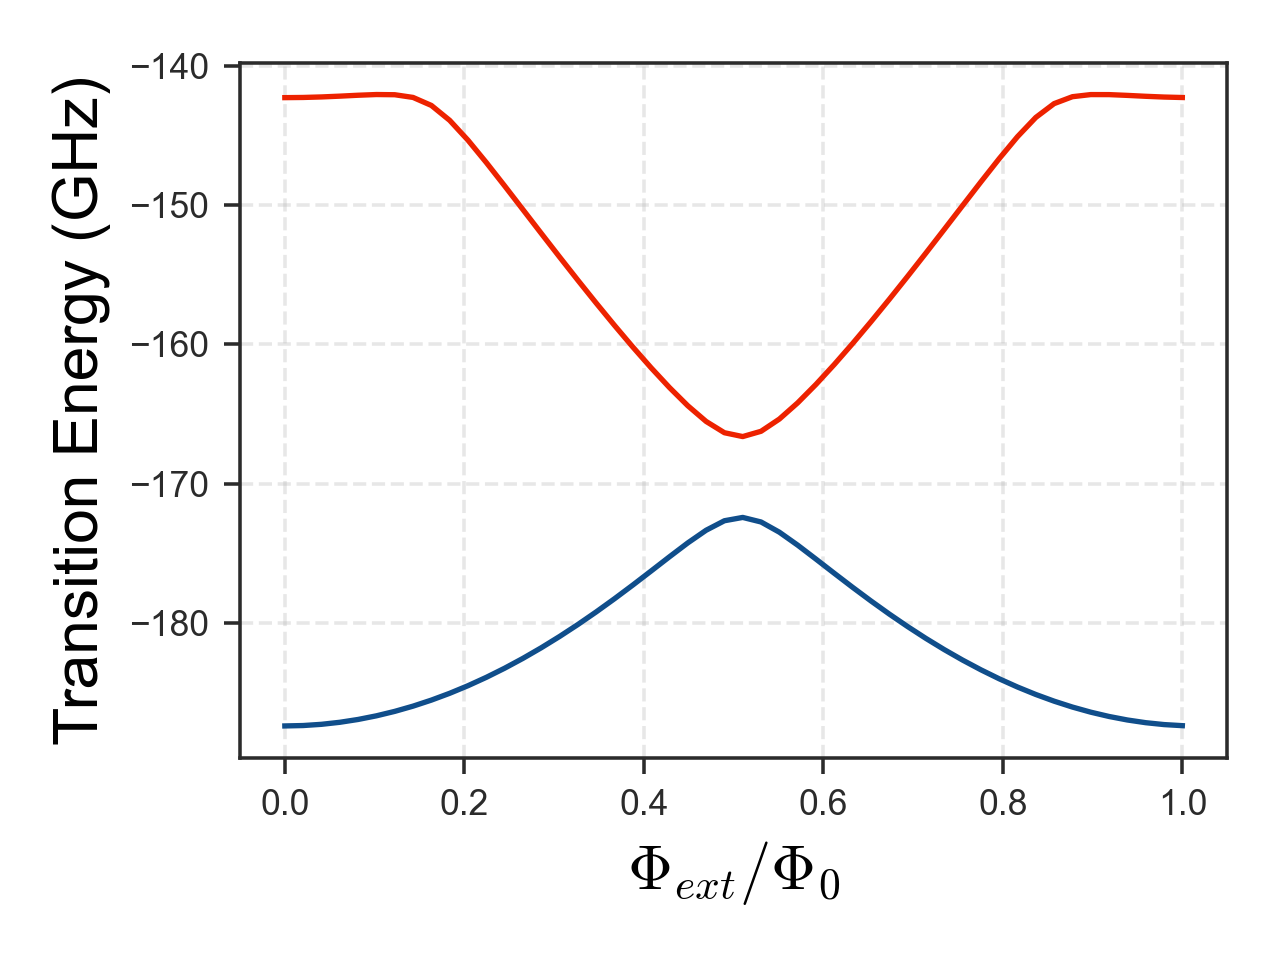

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

flux = np.linspace(0, 1, 50)
# ax.plot(flux, test.spectrum_simulation_12[:50])
# ax.plot(flux, test.spectrum_simulation_12[:50])

ax.plot(flux, test.spectrum_eigvals[:50, 0], color=MY_COLOURS["DarkBlue"])
ax.plot(flux, test.spectrum_eigvals[:50, 1], color=MY_COLOURS["DarkRed"])

ax.set_ylabel("Transition Energy (GHz)", fontsize=14)
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=14)
plt.tight_layout()
# ax.plot(flux, test.spectrum_simulation_12[:50])

# ax.set_ylim([0, 50])
plt.savefig("flux-simulation.svg")